In [5]:
from tool import *
def fill_albedo2(month,type,sza_L,interp_2000=False):
    max_distance=3
    distence_w_dim=torch.load(root_path+'information_val2/weights.pth')[type]
    sza_L_month=sza_L[0,month-1]
    # distence_w_dim=[1,1,1,1]
    bands=['albedo_BSA_vis', 
        'albedo_WSA_vis', 
        'albedo_BSA_nir', 
        'albedo_WSA_nir', 
        'albedo_BSA_shortwave', 
        'albedo_WSA_shortwave']
    # band='albedo_BSA_vis'

    # m_index=[(month-3)%12+1,(month-2)%12+1,(month-1)%12+1,(month)%12+1,(month+1)%12+1]
    m_index=[(month-2)%12+1,(month-1)%12+1,(month)%12+1]
    offset=[1 if m_index[j]-m_index[0]>=0 else -1 for j in range(len(m_index))]
    if np.array(offset).sum()==len(offset):
        offset=[0]*len(m_index)
    # print(month,m_index,offset)

    vs=[]
    ms=[]
    land_proportions=[]
    for i in range(len(offset)):    
        NC=nc.Dataset(root_path+f'information_temp/month_{m_index[i]}.nc','r')
        for band in bands:
            vs.append(NC.variables[f'{band}-{type}'][:])
        if type!='ocean':
            ms.append(NC.variables[f'area-{type}'][:])
        # qa=NC.variables['qa'][:]
        area_grid=NC.variables['area-grid'][:]
        area_land=NC.variables['area-land'][:]
        land_proportions.append(area_land/area_grid)
        NC.close()
    offset_bands=[]
    for i in offset:
        offset_bands+=[i]*len(bands)
    if offset[0]!=0:
        nan_array=np.zeros((1,180,360))*np.nan
        vs=[np.concatenate((nan_array,vs[i]),axis=0) if offset_bands[i]==1 else np.concatenate((vs[i],nan_array),axis=0) for i in range(len(offset_bands))]
        land_proportions=[np.concatenate((nan_array,land_proportions[i]),axis=0) if offset[i]==1 else np.concatenate((land_proportions[i],nan_array),axis=0) for i in range(len(offset))]
        if type!='ocean':
            ms=[np.concatenate((nan_array,ms[i]),axis=0) if offset[i]==1 else np.concatenate((ms[i],nan_array),axis=0) for i in range(len(offset))]
        else:
            ms=land_proportions  
    else:
        if type=='ocean':
            ms=land_proportions  
    M,H,W=vs[0].shape
    v=np.stack(vs).reshape((len(offset),len(bands),M,H,W)).transpose((1,0,2,3,4))#(6, 3, 21, 180, 360)

    # vv=[v[:,i] for i in range(len(bands))]
    m=np.stack(ms)
    # plt.imshow(v[0,1,1])
    # plt.show()
    # land_proportion=np.stack(land_proportions)
    # print(month,m_index,v.shape)
    all_indices = np.indices(v[0].shape).reshape(4, -1).T
    
    

    
    
    if interp_2000:
        if type!='ocean':
                interp_indices = all_indices[((v[0]==2000) & (m>0)).reshape(-1)]
        else:
            interp_indices = all_indices[((v[0]==2000) & (m<1) & (m>0)).reshape(-1)]
        nonan_indices=all_indices[((~np.isnan(v[0])).reshape(-1)) & ((v[0]!=2000).reshape(-1))]
    else:
    
        if type!='ocean':
            interp_indices = all_indices[(np.isnan(v[0]) & (m>0)).reshape(-1)]
        else:
            interp_indices = all_indices[(np.isnan(v[0]) & (m<1) & (m>0)).reshape(-1)]
        nonan_indices=all_indices[(~np.isnan(v[0])).reshape(-1)]
    
    
    
    
    # print(len(nonan_indices))
    interp_indices=[j for j in interp_indices if j[0]==int(len(offset)/2)]  
    interp_indices=[j for j in interp_indices if sza_L_month[j[2],j[3]]<2] #只插值天顶角小于85的
    nonan_indices2=[j for j in nonan_indices if j[0]==int(len(offset)/2)]  
    nonan_indices2=[j for j in nonan_indices2 if sza_L_month[j[2],j[3]]<2]
    # interp_values=[]
    # search_n=1
    # print(month,type,len(interp_indices),round(len(interp_indices)/(len(nonan_indices)+len(interp_indices))*100,2),'%')
    str_output=f'{month}-{type}  '+str(len(interp_indices))+'  '+str(round(len(interp_indices)/(len(nonan_indices2)+len(interp_indices)+0.01)*100,2))+'%'
    # for interp_indice in tqdm(interp_indices):
    #     k=TS_IDM_4d(interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim)
    #     while np.isnan(k):
    #         search_n*=2
    #         k=TS_IDM_4d(interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim)

    #     interp_values.append(k)
    time.sleep(1)
    kk=[search_nonan2(v,interp_indice,max_distance=max_distance,distence_w_dim=distence_w_dim,interp_2000=interp_2000) for interp_indice in tqdm(interp_indices,desc=str_output)]
    interp_values=np.array([a[0] for a in kk])
    dws=np.array([a[1] for a in kk])
    # print('fill value '+str((1-np.isnan(interp_values).sum()/interp_values.shape[0])*100)+'%')
    dws_v=np.zeros(v.shape)
    for z in range(len(interp_indices)):
        v[:,interp_indices[z][0],interp_indices[z][1],interp_indices[z][2],interp_indices[z][3]]=np.array(interp_values[z])
        dws_v[:,interp_indices[z][0],interp_indices[z][1],interp_indices[z][2],interp_indices[z][3]]=np.array(dws[z])
    # print(v.shape,dws_v.shape)
    if offset[int(len(offset)/2)]>=0:
        return v[:,int(len(offset)/2),offset[int(len(offset)/2)]:],dws_v[:,int(len(offset)/2),offset[int(len(offset)/2)]:]
    else:
        return v[:,int(len(offset)/2),:-1],dws_v[:,int(len(offset)/2),:-1]
def TS_IDM_4d_2(v,interp_indice,max_distance,distence_w_dim,interp_2000):
    
        value=v[zero(interp_indice[0]-int(max_distance/distence_w_dim[0])):interp_indice[0]+int(max_distance/distence_w_dim[0])+1,
                zero(interp_indice[1]-int(max_distance/distence_w_dim[1])):interp_indice[1]+int(max_distance/distence_w_dim[1])+1,
                zero(interp_indice[2]-int(max_distance/distence_w_dim[2])):interp_indice[2]+int(max_distance/distence_w_dim[2])+1,
                zero(interp_indice[3]-int(max_distance/distence_w_dim[3])):interp_indice[3]+int(max_distance/distence_w_dim[3])+1]
        non_nan_indices = np.where(~np.isnan(value))
        
        
        if interp_2000:
            v[v==2000]=np.nan
        
        
        non_nan_points = np.array(list(zip(non_nan_indices[0], non_nan_indices[1], non_nan_indices[2],non_nan_indices[3])))
         
        if len(non_nan_points)==0:
                interpolated_value=np.nan
                dws=np.nan
        else:
                k=np.array([zero(-interp_indice[0]+int(max_distance/distence_w_dim[0]))-int(max_distance/distence_w_dim[0]),
                        zero(-interp_indice[1]+int(max_distance/distence_w_dim[1]))-int(max_distance/distence_w_dim[1]),
                        zero(-interp_indice[2]+int(max_distance/distence_w_dim[2]))-int(max_distance/distence_w_dim[2]),
                        zero(-interp_indice[3]+int(max_distance/distence_w_dim[3]))-int(max_distance/distence_w_dim[3])])
                # print(k)
                # print(non_nan_points)
                non_nan_points+=k
                distance_s = np.array([np.linalg.norm(np.array(non_nan_points[i])*np.array(distence_w_dim)) for i in range(len(non_nan_points))])
                if len(distance_s)<10:
                        interpolated_value=np.nan
                        dws=np.nan
                else:
                        kth = np.partition(distance_s, 9)[9]
                        distance=distance_s.copy()
                        distance1=distance_s.copy()
                        distance1=distance1[distance_s<=kth]
                        weights = 1.0 / distance1**2
                        dws=np.sum(weights)
                        weights /= dws
                        non_nan_values = value[non_nan_indices]
                        non_nan_values=non_nan_values[distance<=kth]
                        interpolated_value = np.sum(weights * non_nan_values)
        return interpolated_value,dws
    
def search_nonan2(v,interp_indice,max_distance,distence_w_dim,interp_2000):
    k_bands=[]
    dws_bands=[]
    search_n=1
    for i in range(6):
        k,dws=TS_IDM_4d_2(v[i],interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim[i],interp_2000=interp_2000)
        while np.isnan(k):
            search_n*=2
            k,dws=TS_IDM_4d_2(v[i],interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim[i],interp_2000=interp_2000)
        k_bands.append(k)
        dws_bands.append(dws)
    
    return k_bands,dws_bands
def zero(k):
    if k<0:
        return 0
    else:
        return k

In [3]:
aaa_pd=pd.read_csv(root_path+'information_val2/nan_coords2.csv')
aaa_pd

Unnamed: 0     y   m  lon  lat       type        sza  sza_L  \
0                0  2001   1  100   31  landtype1  51.370184    0.0   
1                1  2001   1  -58  -19  landtype1   2.996200    0.0   
2                2  2001   1   96   25  landtype1  45.378026    0.0   
3                3  2001   1  101   27  landtype1  47.375239    0.0   
4                4  2001   1  -83   36  landtype1  56.364630    0.0   
...            ...   ...  ..  ...  ...        ...        ...    ...   
538385       95995  2020  12   41   53       snow  75.475947    1.0   
538386       95996  2020  12  157  -73       snow  50.541488    0.0   
538387       95997  2020  12  -75  -85       snow  62.536635    0.0   
538388       95998  2020  12  170  -83       snow  60.537359    0.0   
538389       95999  2020  12   76  -87       snow  64.535936    0.0   

        main_band1  main_band2  main_band3  main_band4  main_band5  main_band6  
0        20.045990   20.618515   114.11950  116.375984    76.32311    77.71246  
1        40.210526   46.000000   157.00000  196.684200   102.68421   125.42105  
2        36.910713   38.982143   178.66072  189.125000   113.50000   119.51786  
3        21.444645   22.585386   130.78479  136.314320    84.61261    87.88188  
4        37.500000   36.200000   181.40000  177.950000   116.75000   114.60000  
...            ...         ...         ...         ...         ...         ...  
538385  697.190300  670.150900   496.03320  462.637100   591.80870   562.22970  
538386  954.744260  956.501340   643.77040  646.128360   808.29755   810.27580  
538387  989.339050  983.595340   716.94420  696.210300   861.17694   848.35110  
538388  893.873600  889.398300   564.76996  556.376200   740.33580   734.11310  
538389  987.315250  977.865400   723.17474  705.799000   863.06600   849.69640  

[538390 rows x 14 columns]

In [4]:
#将验证点的数值设为2000
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
for m in range(1,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_temp/month_{m}.nc','r+')
    for landtype in landtypes:
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            aa_type=aaa_pd[(aaa_pd.type==landtype) & (aaa_pd.m==m)]
            for ind, row in aa_type.iterrows():
                img[row['y']-2001,90-row['lat'],row['lon']+180]=2000
            NC.variables[f'{band}-{landtype}'][:]=img
            NC.sync()
    NC.close()

1
2
3
4
5
6
7
8
9
10
11
12


In [6]:
#fill albedo
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
for month in [1,2,3]:
    NC=nc.Dataset(root_path+f'information_val3/month_{month}.nc','r+')
    for type in landtypes:
        v_fill,dws=fill_albedo2(month,type,sza_L,True)
        for band_i in range(len(bands)):
            NC.variables[f'{bands[band_i]}-{type}'][:]=v_fill[band_i]
            try:
                NC.createVariable(f'DWS-{type}-{bands[band_i]}', 'f4', ("time", "latitude", "longitude"))
            except:
                pass
                # print(f'DWS-{type}-{bands[band_i]} have existed')
            NC.variables[f'DWS-{type}-{bands[band_i]}'][:]=dws[band_i]
    NC.close()

1-landtype14  840  1.19%: 100%|██████████| 840/840 [00:17<00:00, 47.88it/s]
1-landtype15  0  0.0%: 0it [00:00, ?it/s]
2-landtype14  956  1.36%: 100%|██████████| 956/956 [00:18<00:00, 51.16it/s]
2-landtype15  0  0.0%: 0it [00:00, ?it/s]
2-snow  7818  2.57%: 100%|██████████| 7818/7818 [02:23<00:00, 54.57it/s]


In [23]:
#添加验证点的ground truth
aaa2=[]
aaa_pd=pd.read_csv(root_path+'information_val2/nan_coords2.csv')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']

bands=['albedo_BSA_vis', 
    'albedo_WSA_vis', 
    'albedo_BSA_nir', 
    'albedo_WSA_nir', 
    'albedo_BSA_shortwave', 
    'albedo_WSA_shortwave']

for m in range(1,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_val3/month_{m}.nc','r')
    for landtype in landtypes:
        kk={}
        aa_type=aaa_pd[(aaa_pd.type==landtype) & (aaa_pd.m==m)]
        n=0
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            kk[band]=[]
            for ind, row in aa_type.iterrows():
                kk[band].append(img[row['y']-2001,90-row['lat'],row['lon']+180])
            n+=1
            aa_type[f'pred_band{n}']=kk[band]
        aaa2.append(aa_type)
    NC.close()
aaa_pd2=pd.concat(aaa2)
# aaa_pd2.to_csv(root_path+'information_val2/nan_coords2.csv')

1
2
3
4
5
6
7
8
9
10
11
12


In [18]:
from tool import *
aaa_pd2=pd.read_csv(root_path+'information_val2/nan_coords2.csv')

In [20]:
set(aaa_pd2['sza_L'])

{0.0, 1.0}

In [12]:
from sklearn.metrics import r2_score,mean_squared_error
bands=['albedo_Black-sky_visible', 
    'albedo_White-sky_visible', 
    'albedo_Black-sky_near-infrared', 
    'albedo_White-sky_near-infrared', 
    'albedo_Black-sky_shortwave', 
    'albedo_White-sky_shortwave']
print('band    R2    RMSE')
for n in range(1,7):
    r2=r2_score(np.array(aaa_pd2[f'main_band{n}'])/1000,np.array(aaa_pd2[f'pred_band{n}'])/1000)
    rmse=np.sqrt(mean_squared_error(np.array(aaa_pd2[f'main_band{n}'])/1000,np.array(aaa_pd2[f'pred_band{n}'])/1000))
    print(bands[n-1],r2,rmse)

band    R2    RMSE
albedo_Black-sky_visible 0.9843532183889014 0.03226351442035204
albedo_White-sky_visible 0.9842039759160973 0.03185195335767489
albedo_Black-sky_near-infrared 0.9795993741121184 0.0213792730192537
albedo_White-sky_near-infrared 0.9777276046566479 0.02112794800448044
albedo_Black-sky_shortwave 0.9832391437061543 0.025665919087565676
albedo_White-sky_shortwave 0.9825296035927576 0.02529835683384462


In [46]:
0.025665919073701138*0.025665919073701138

0.0006587394018977759

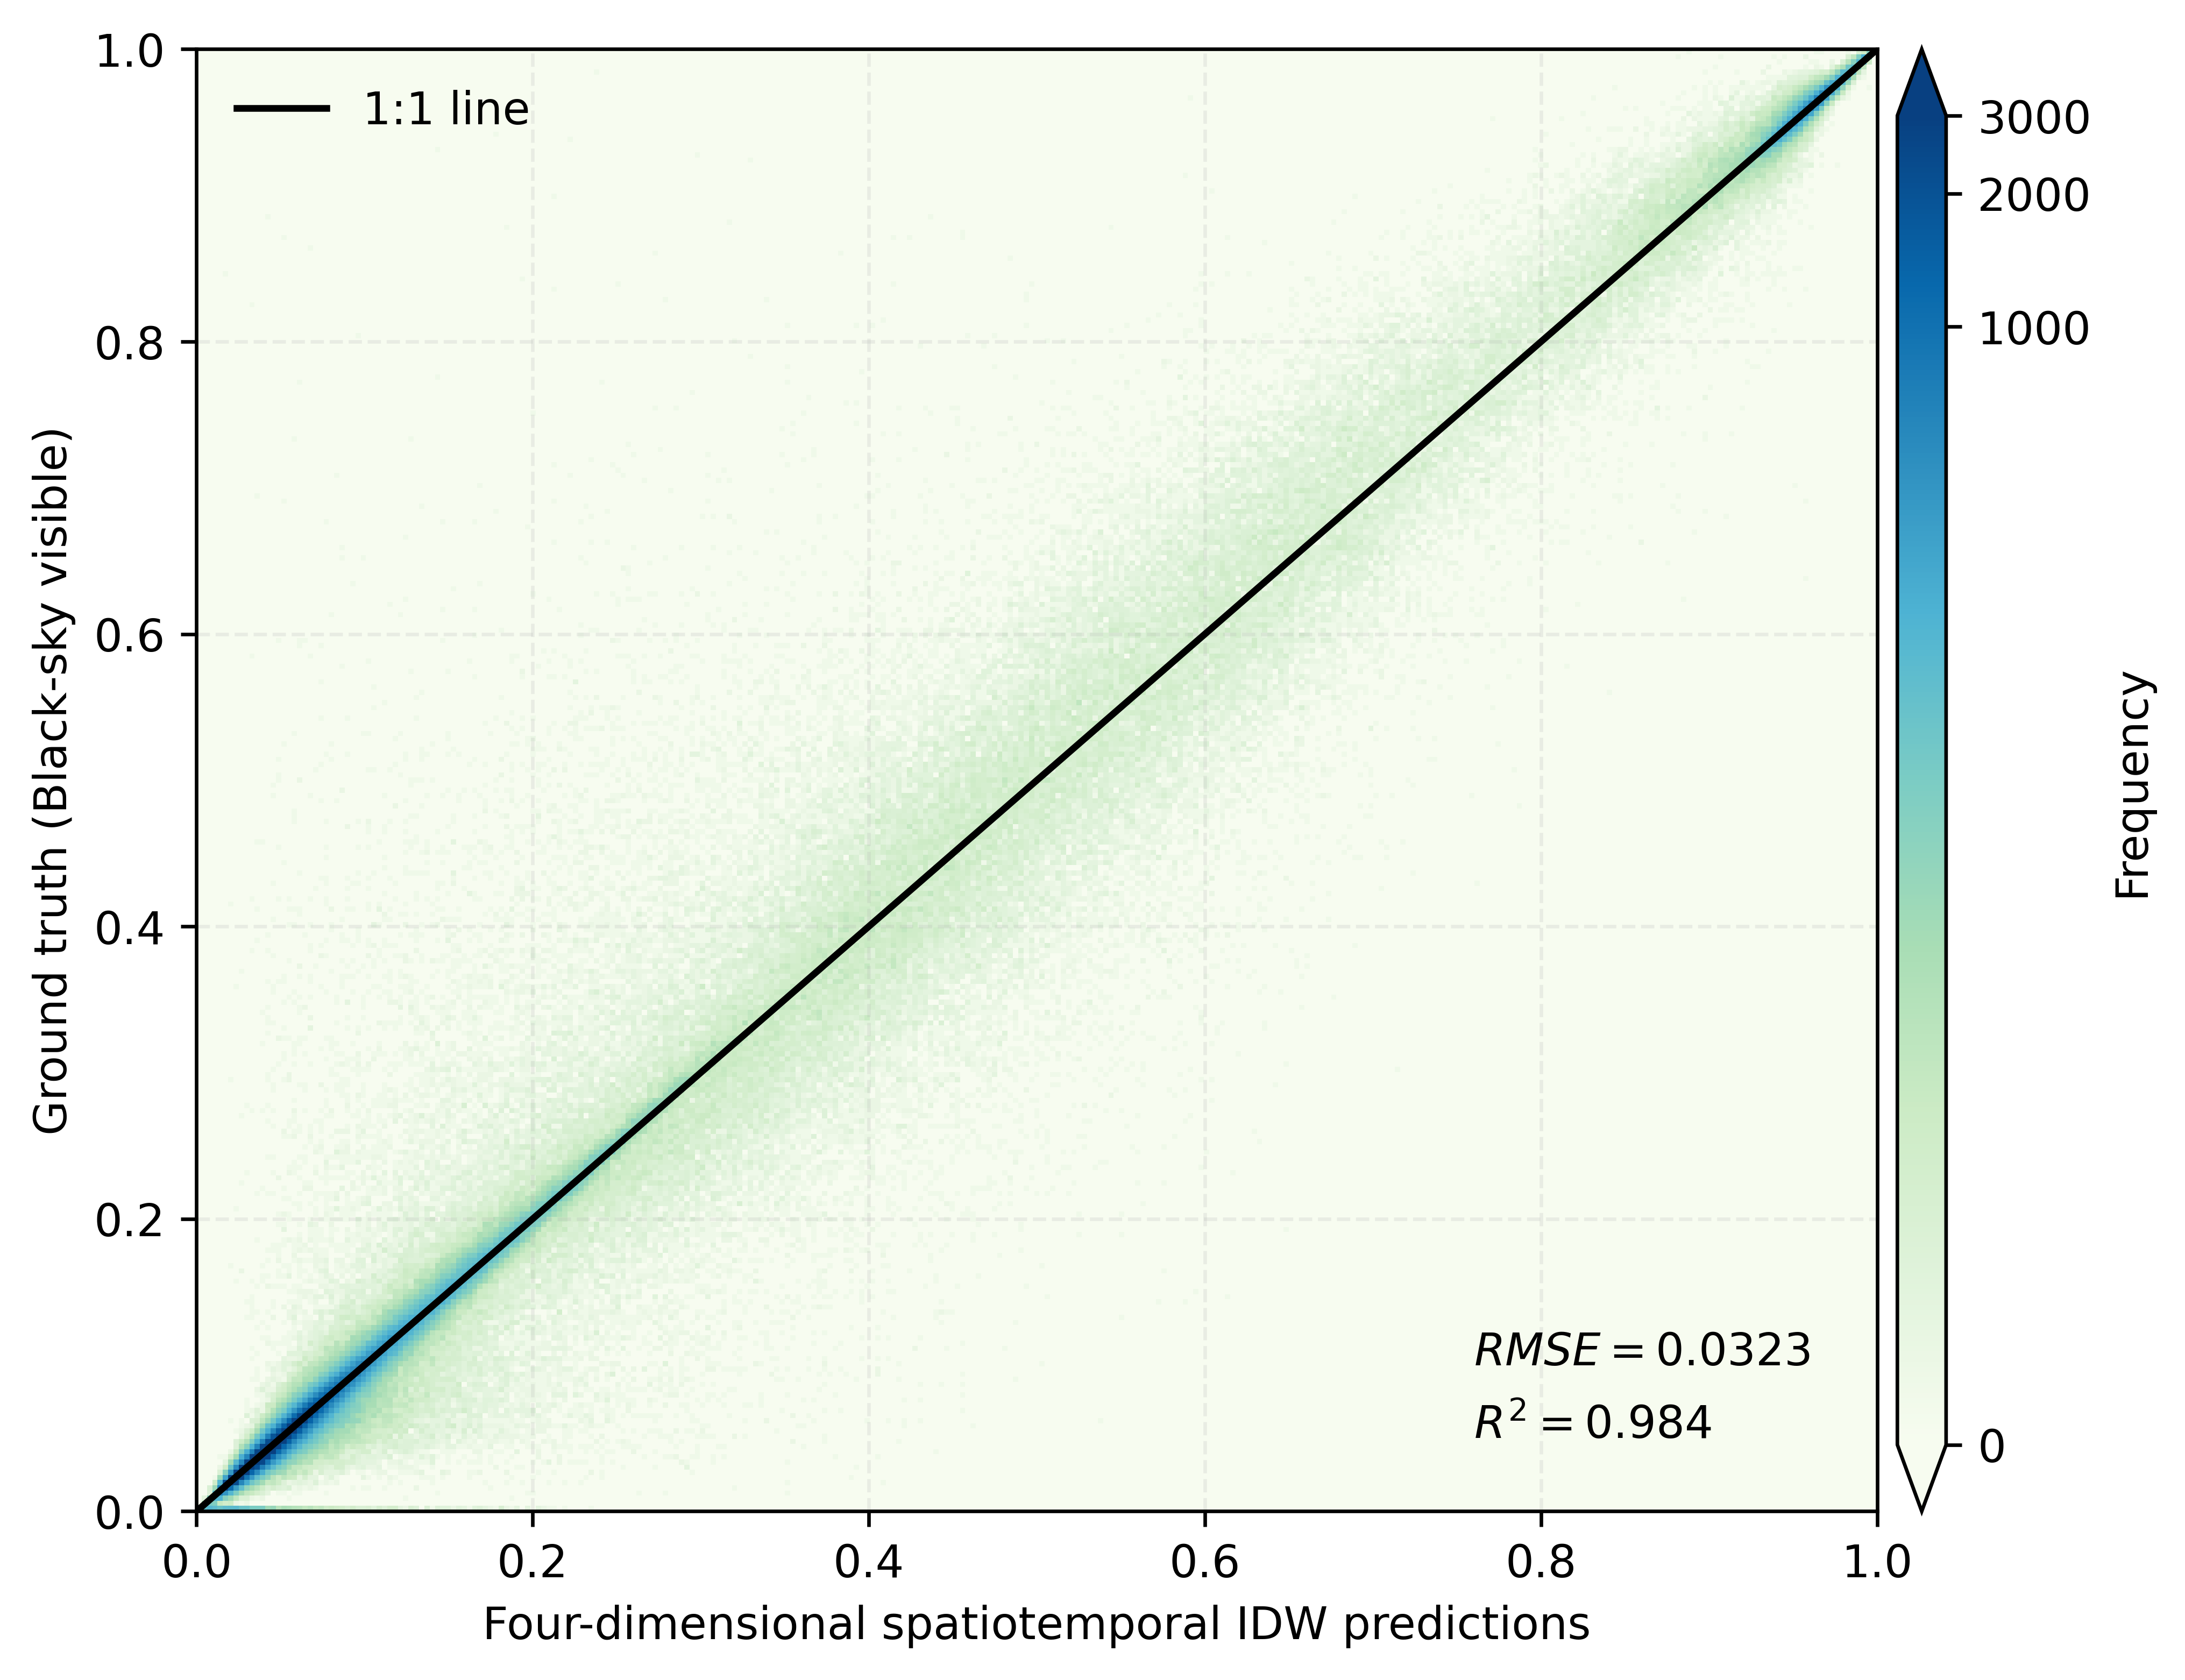

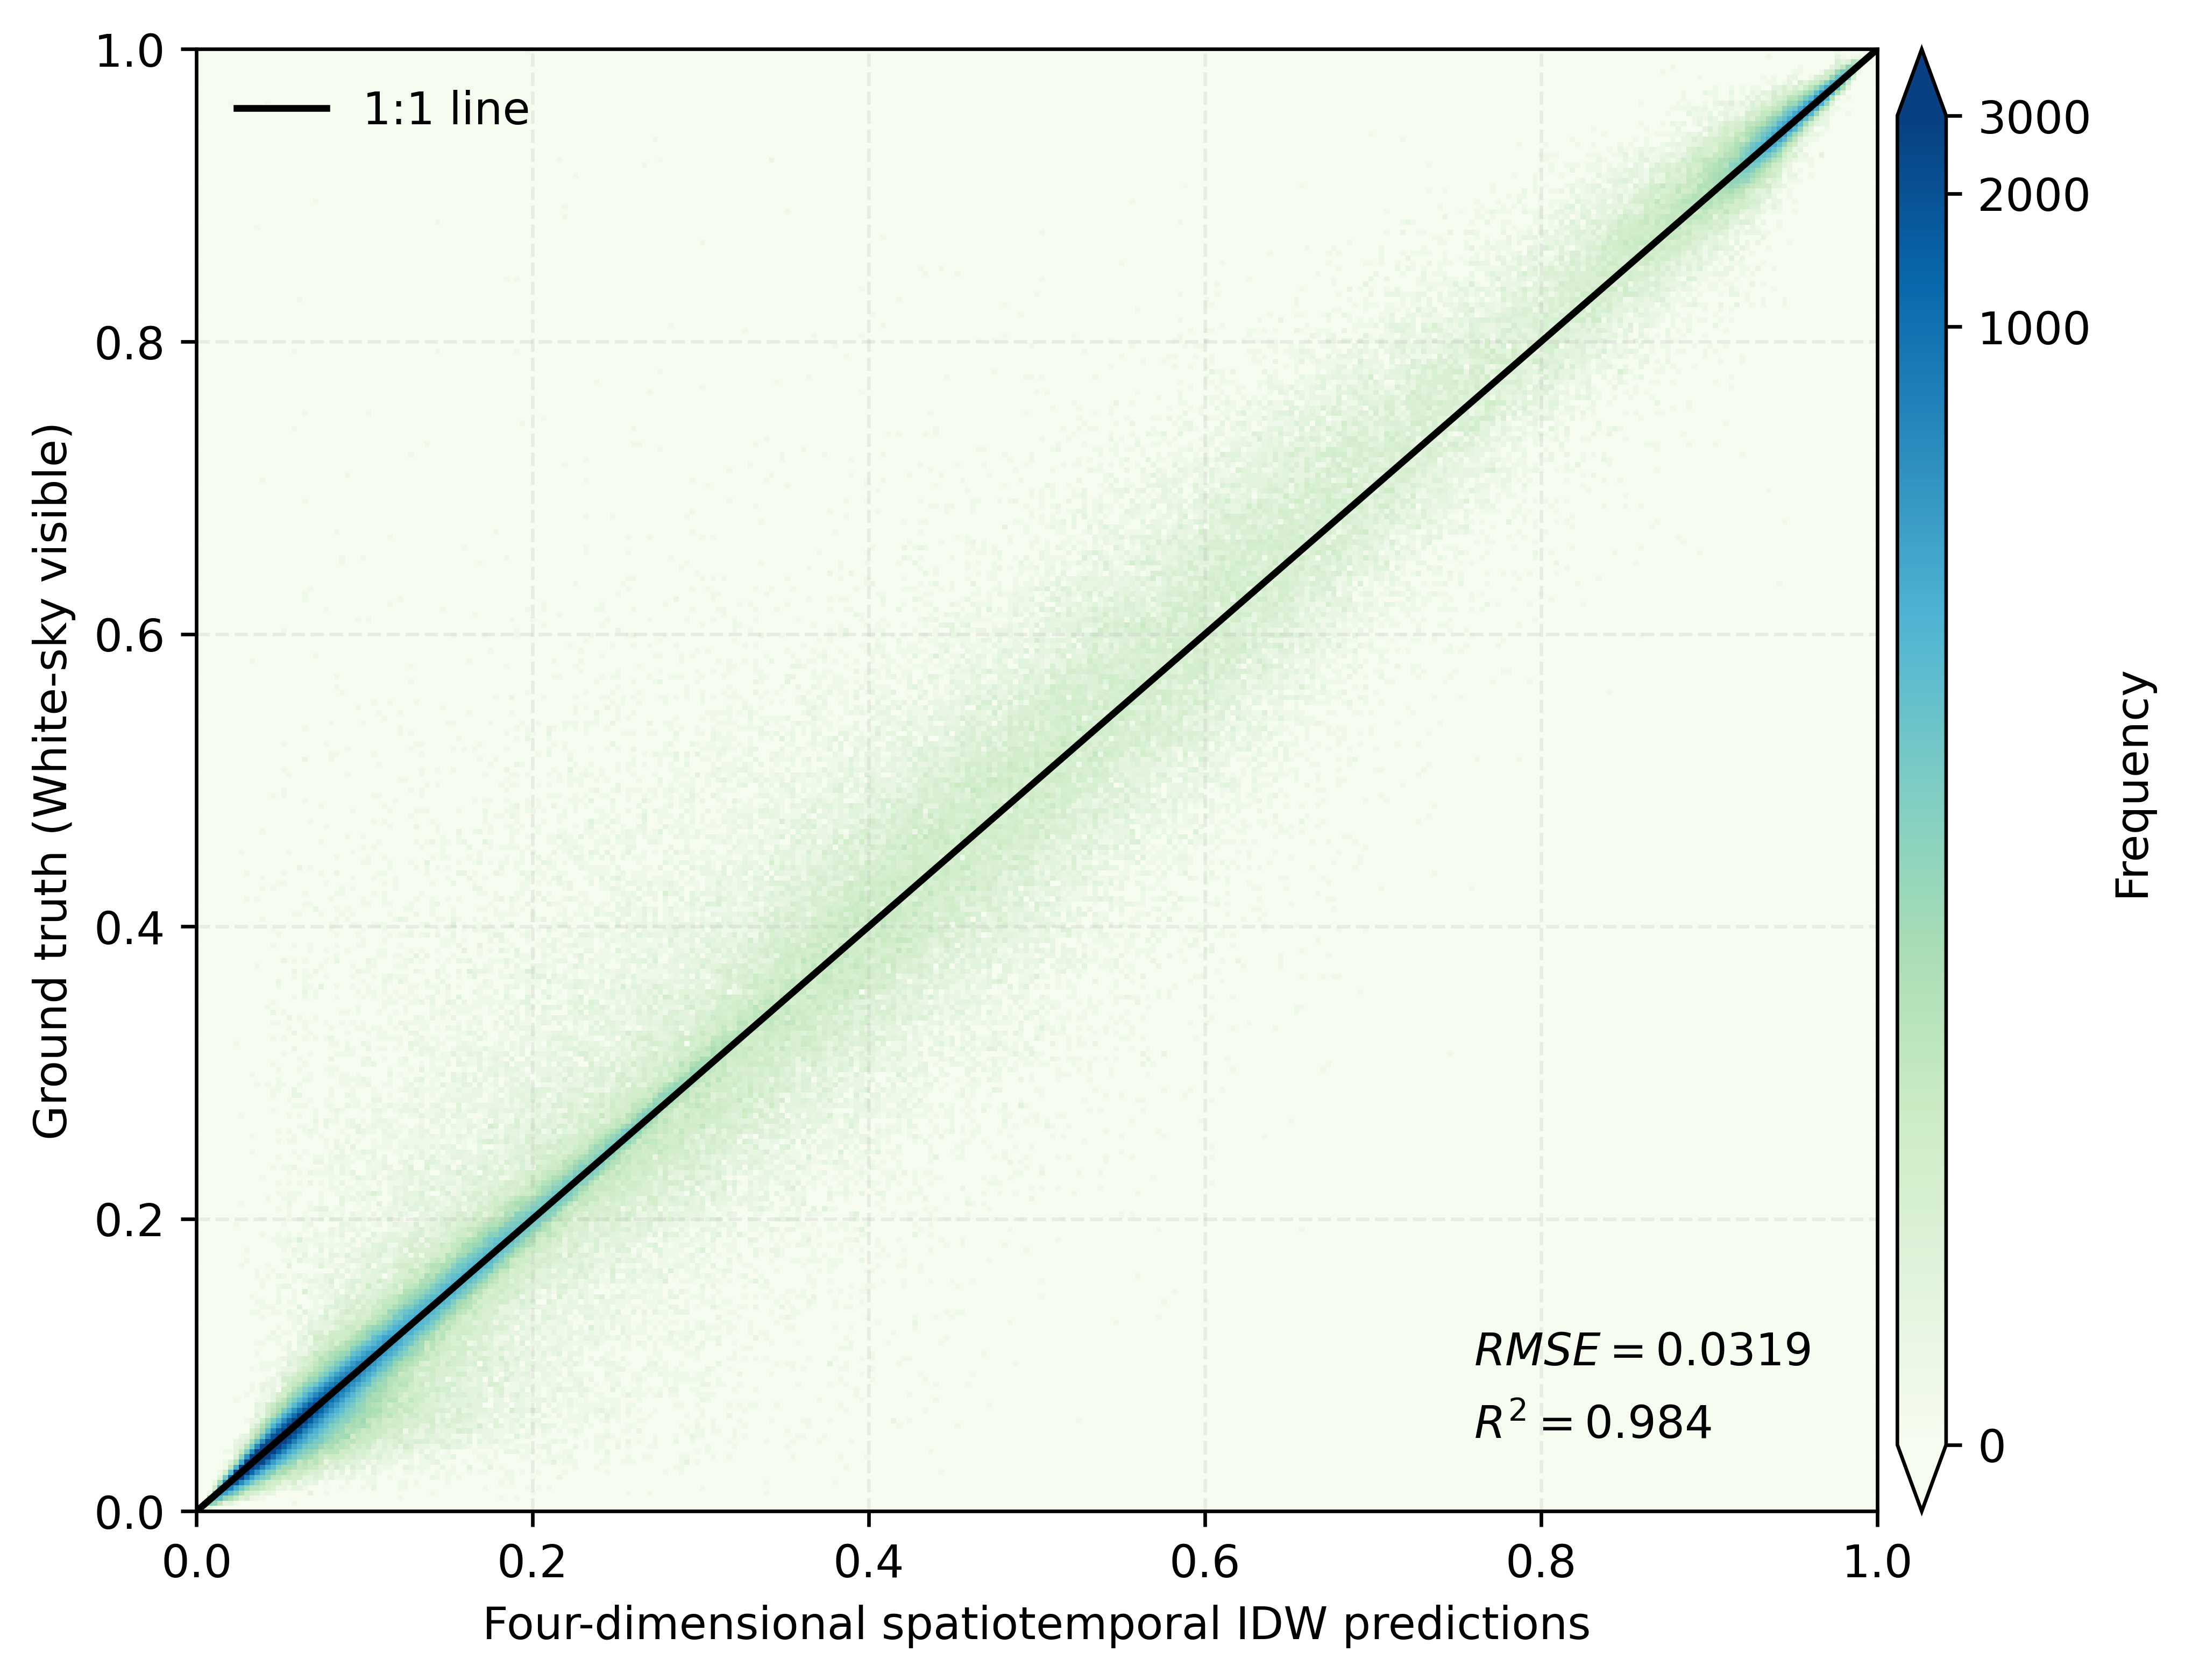

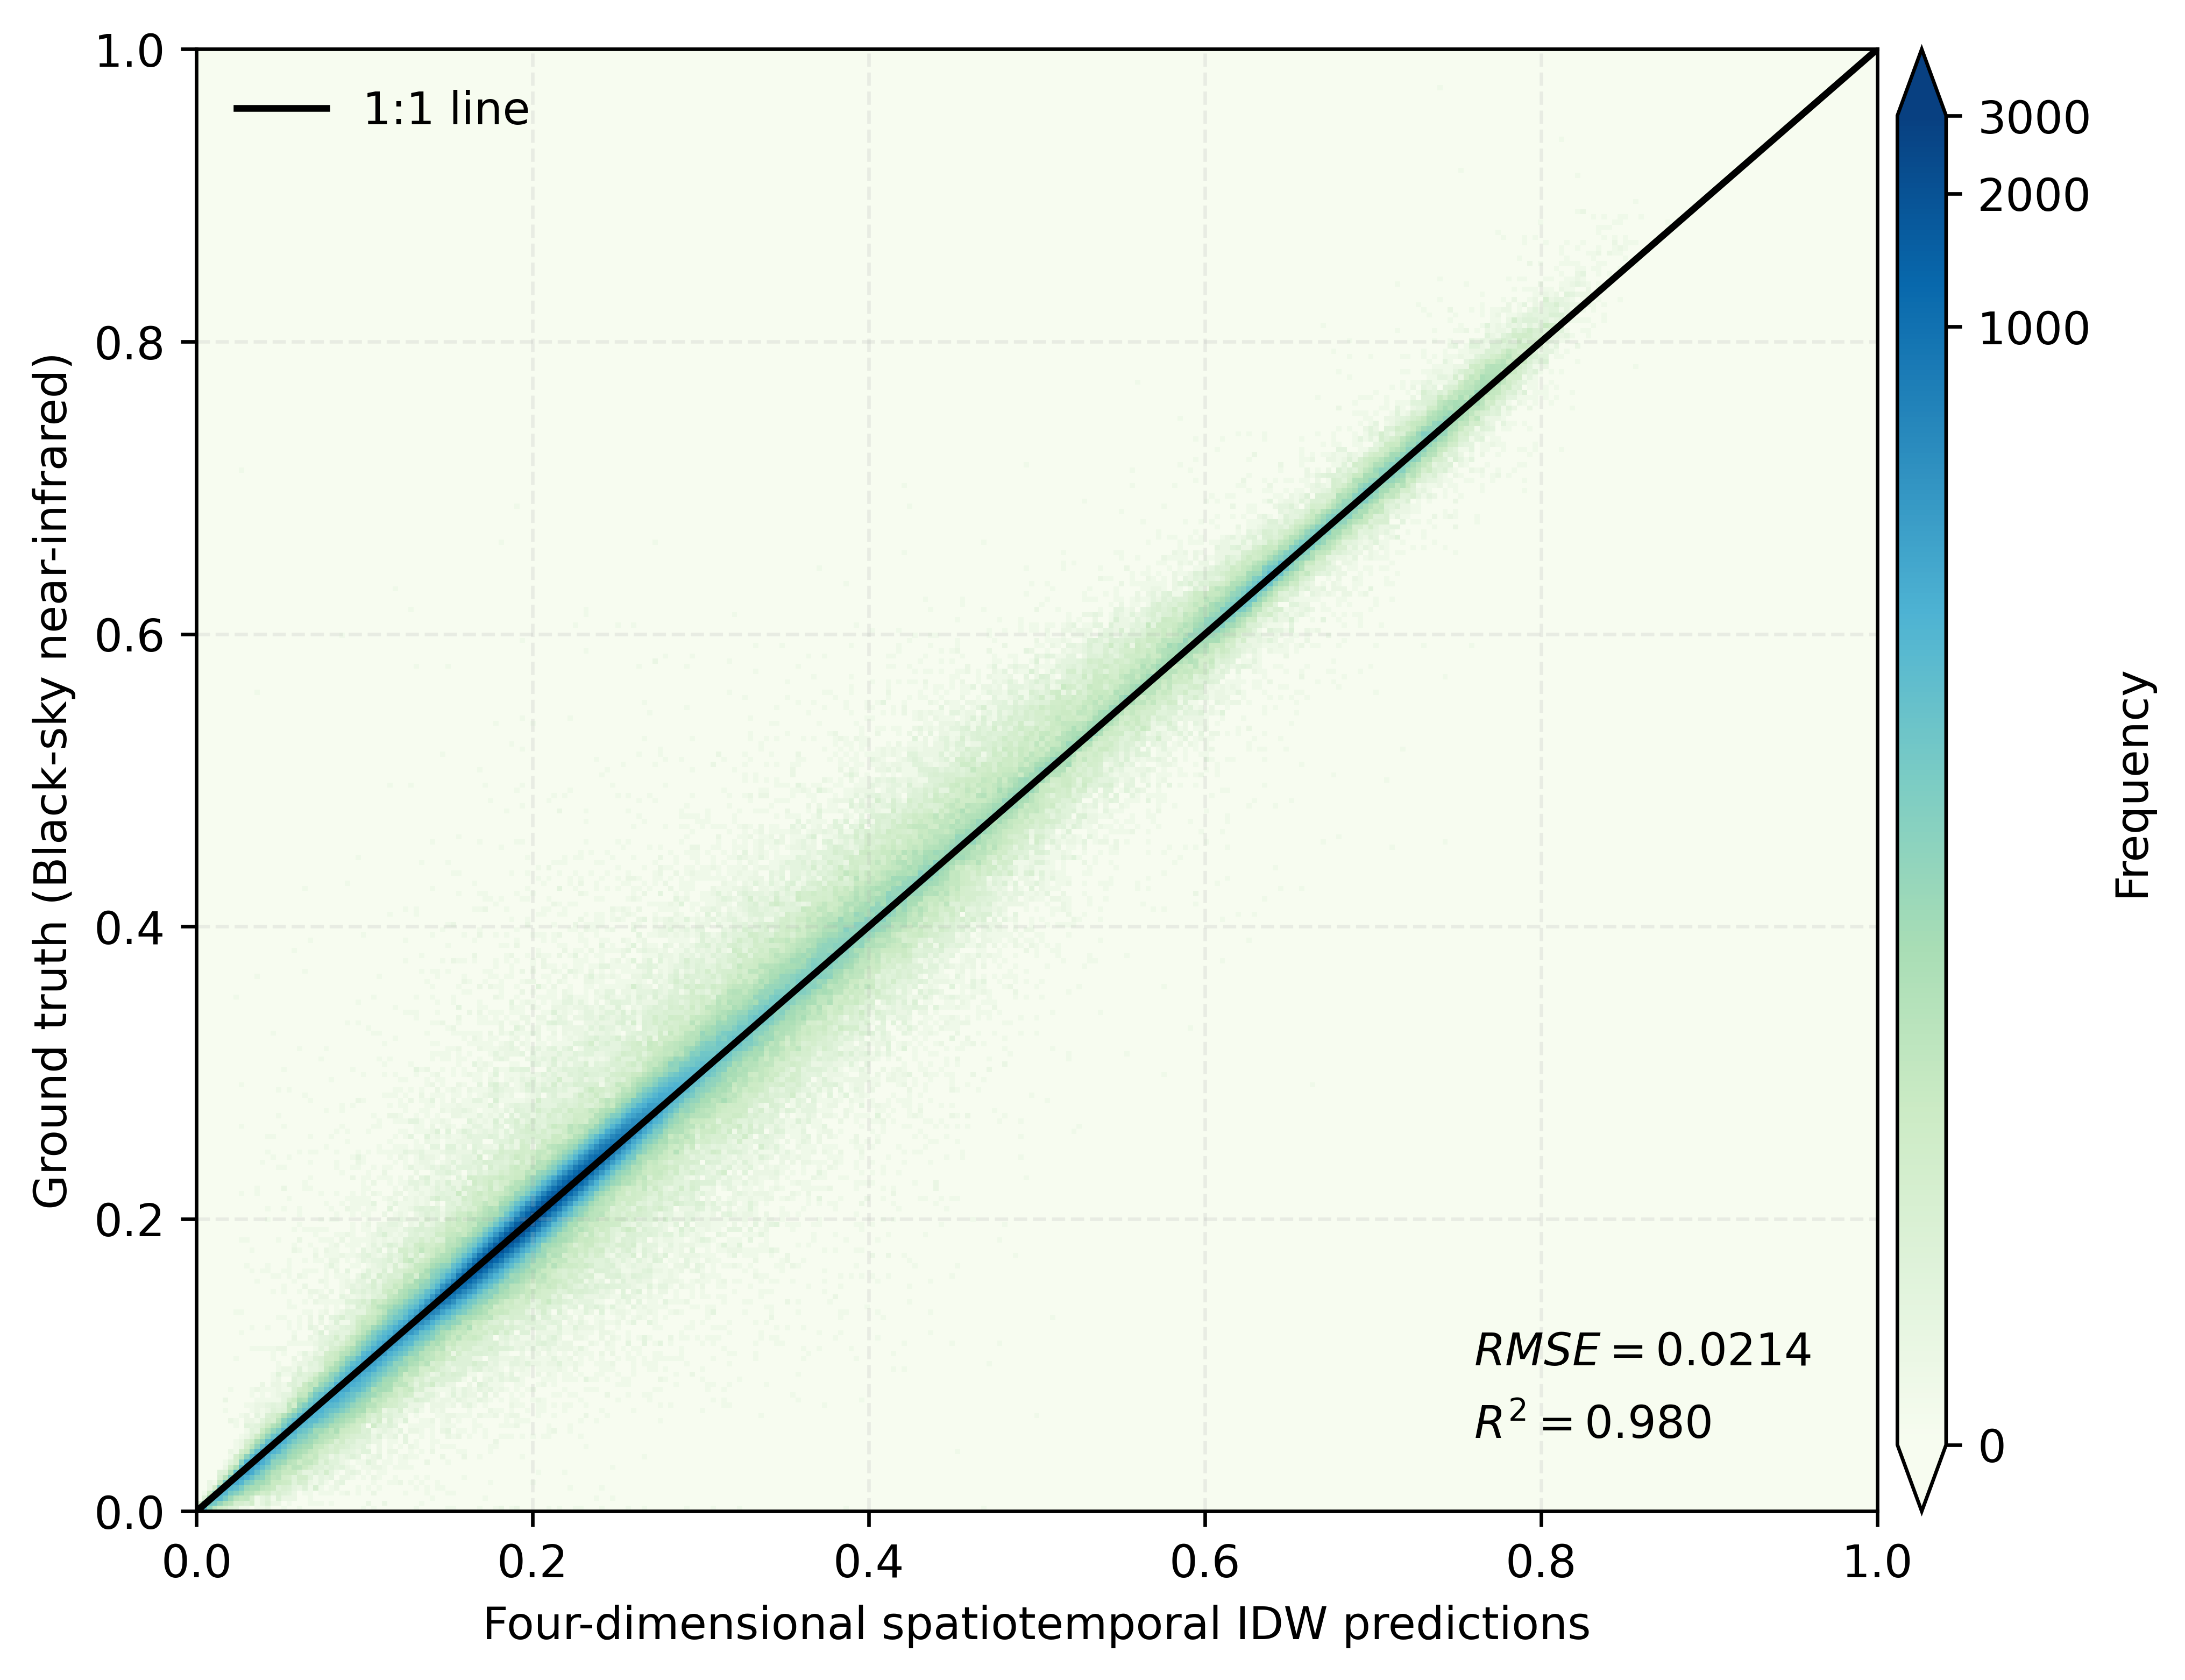

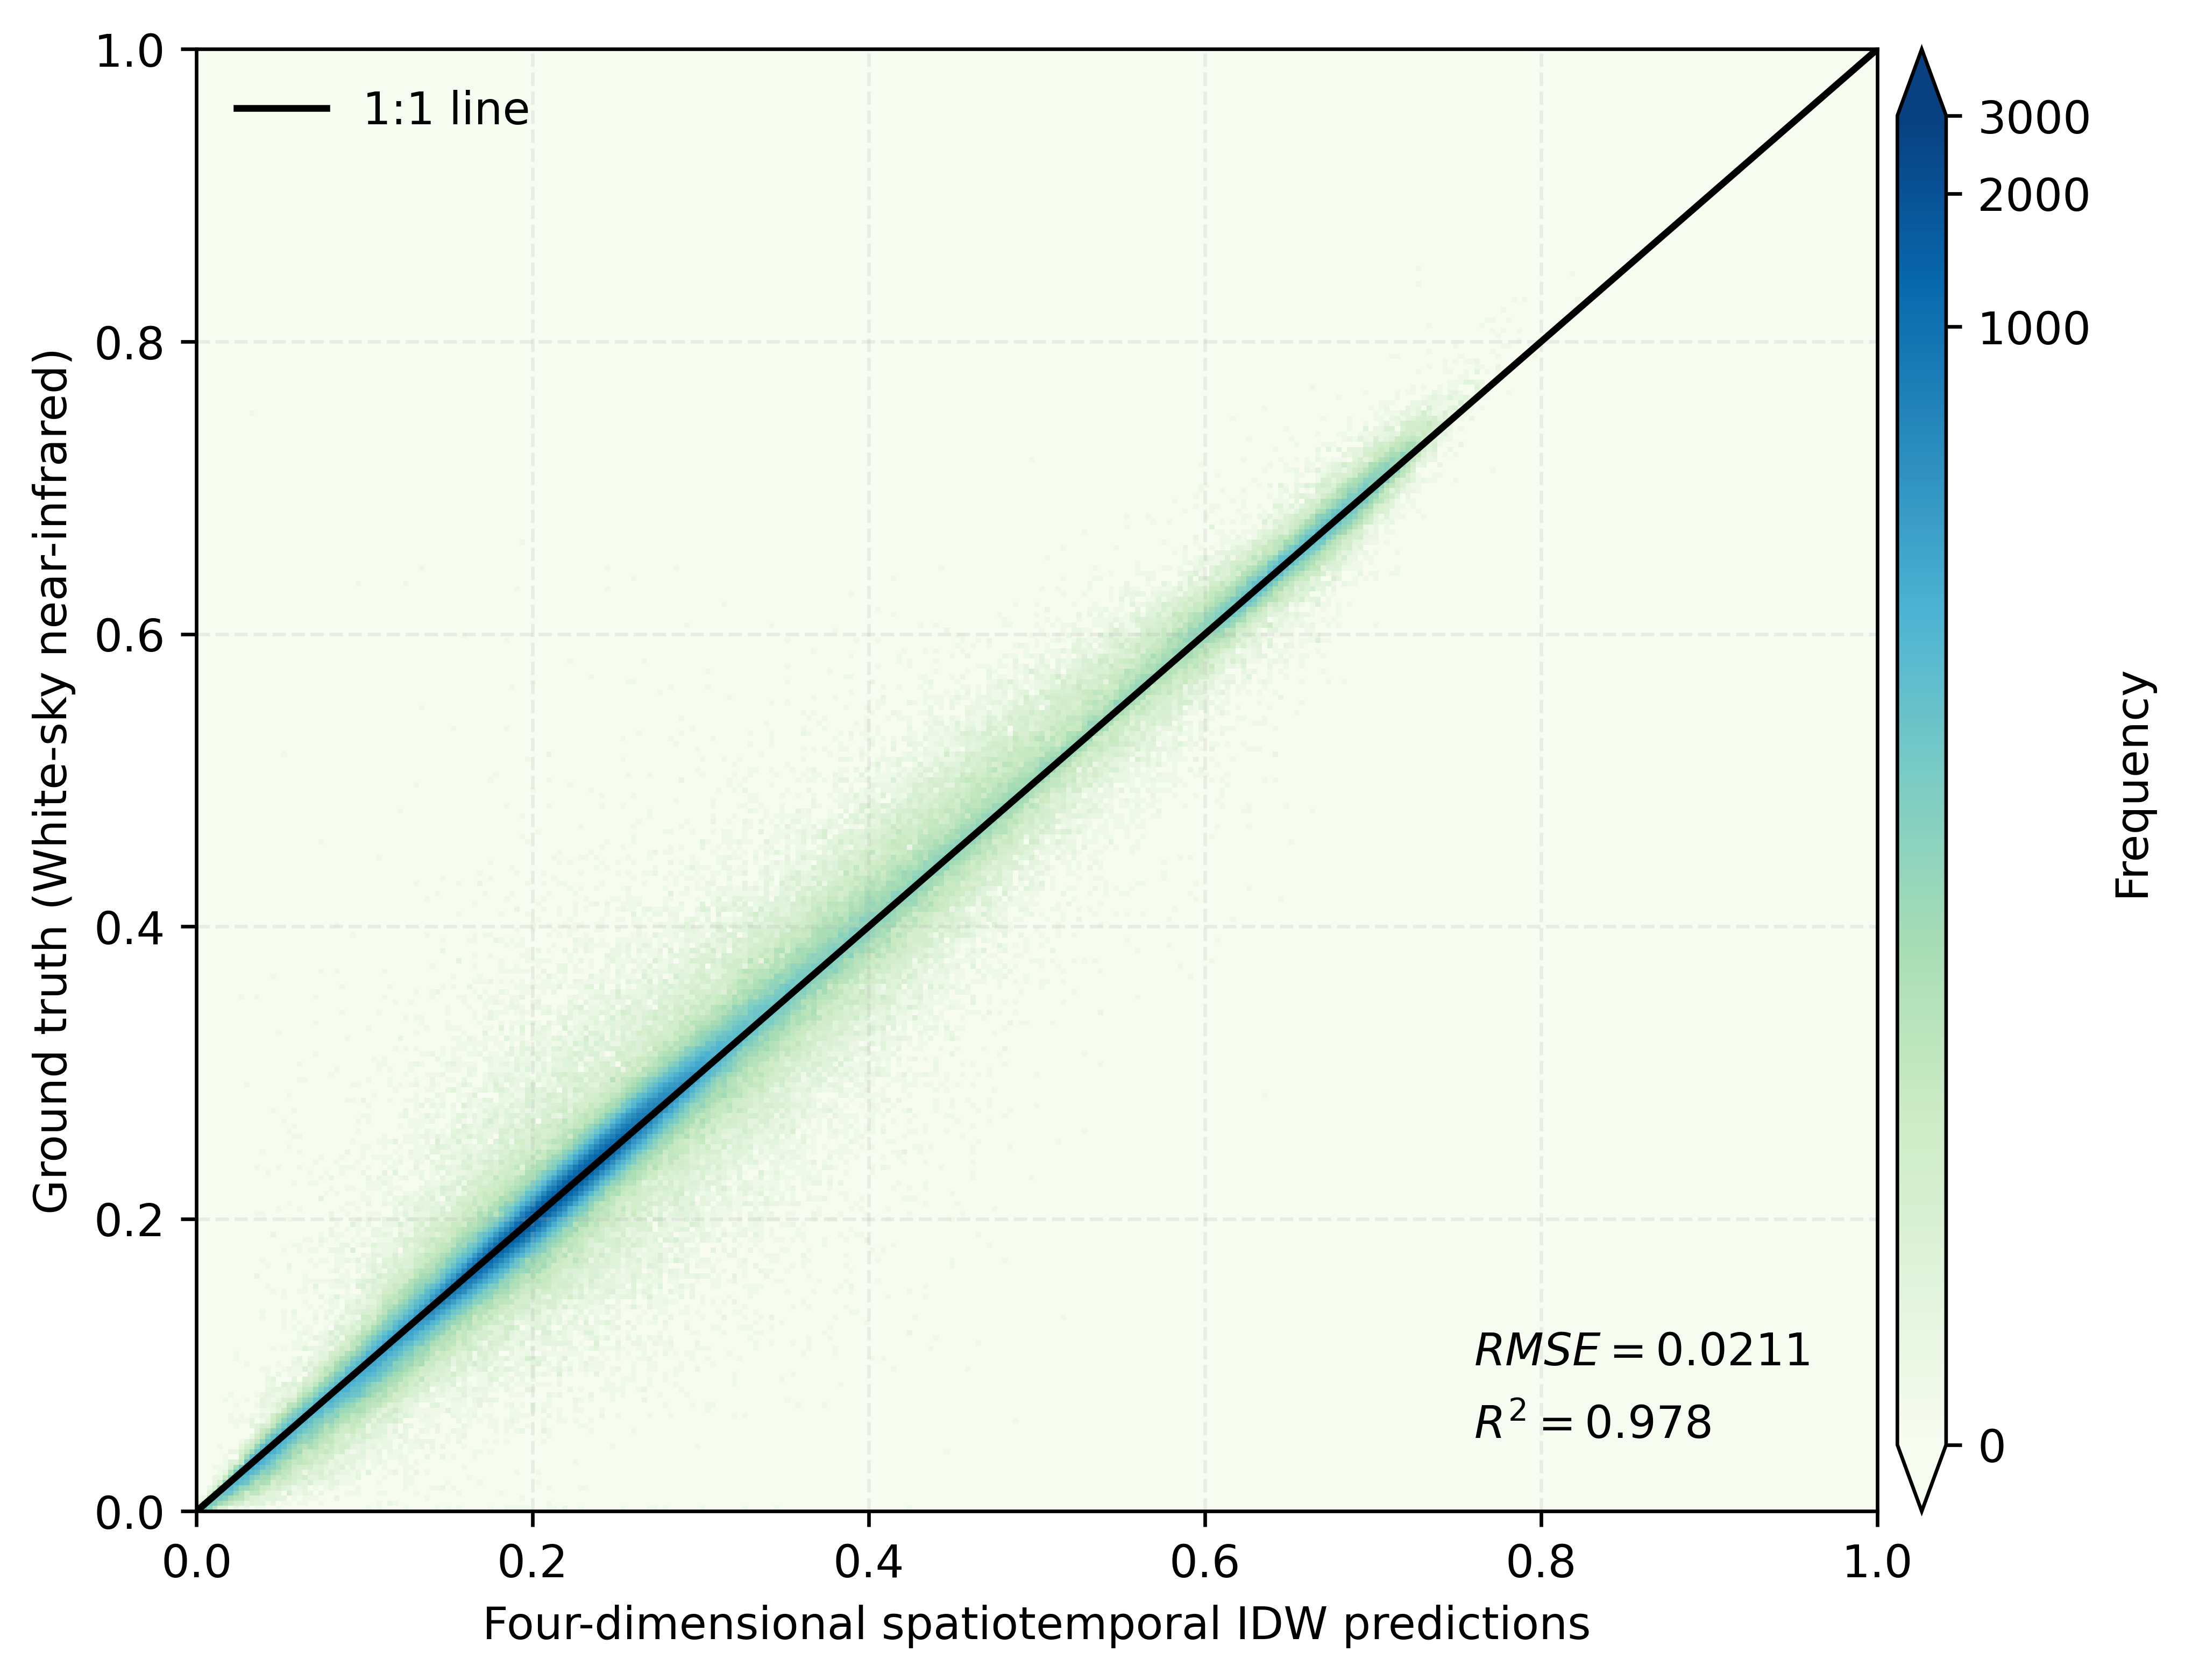

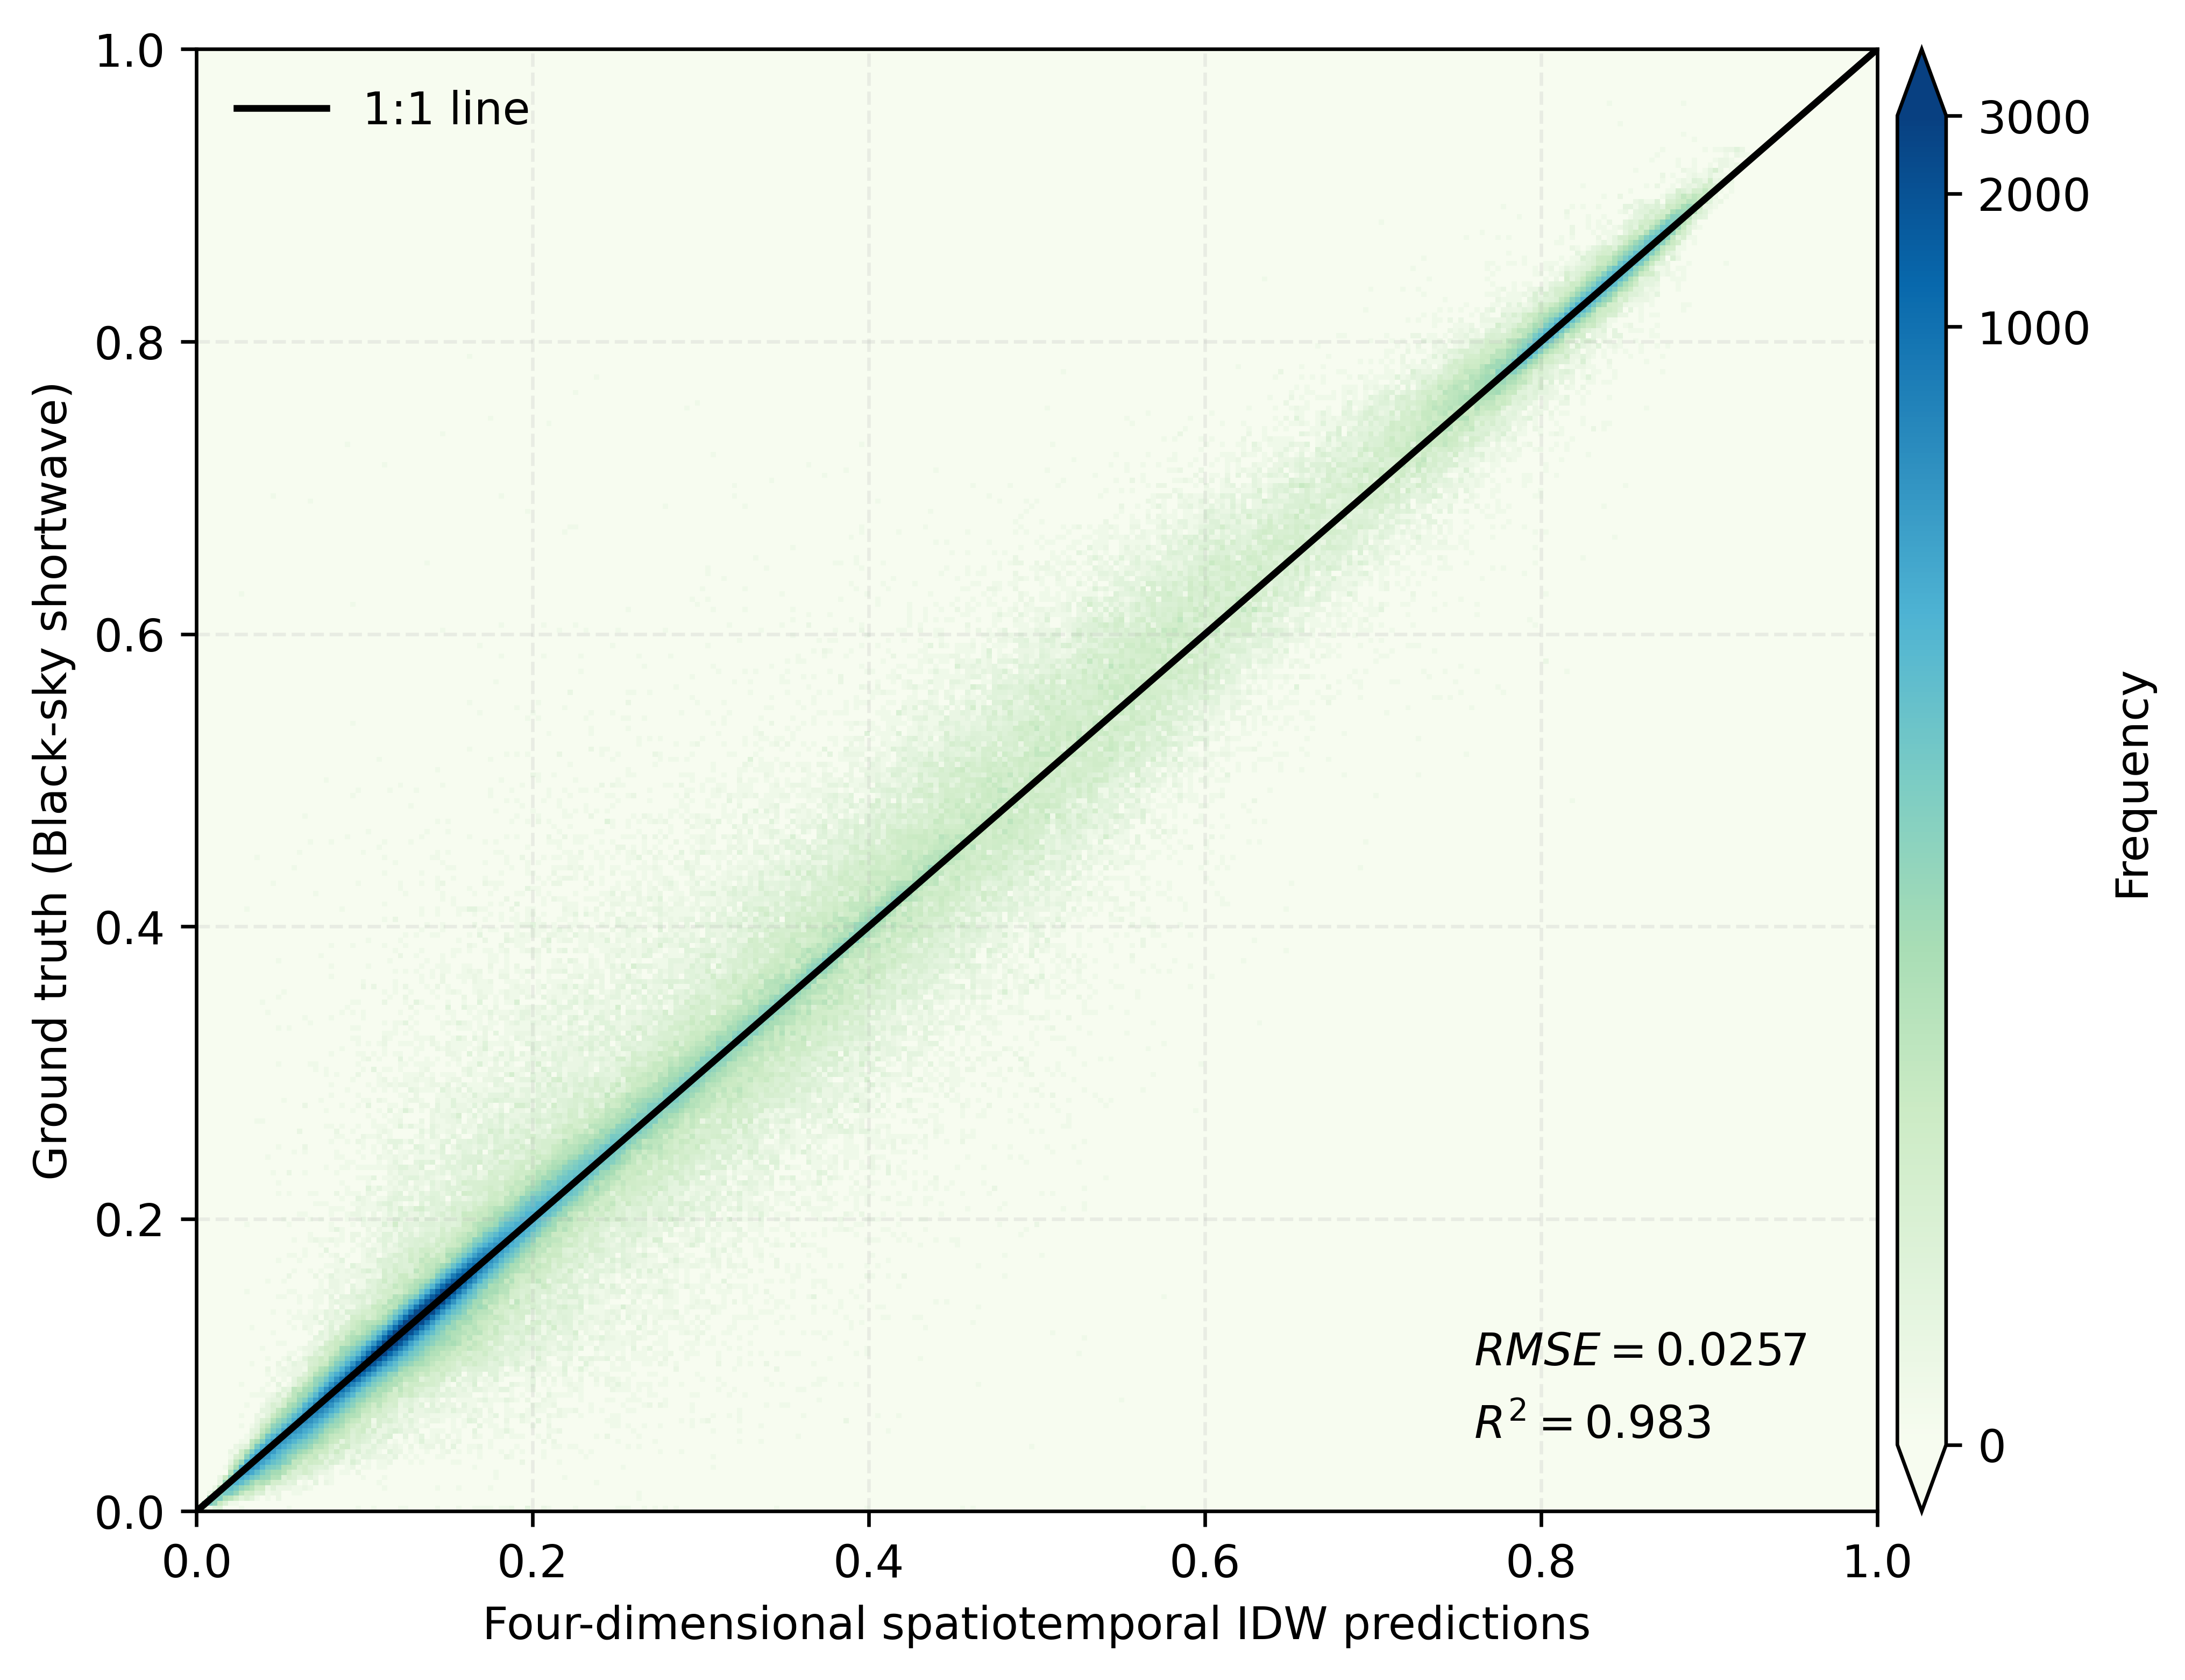

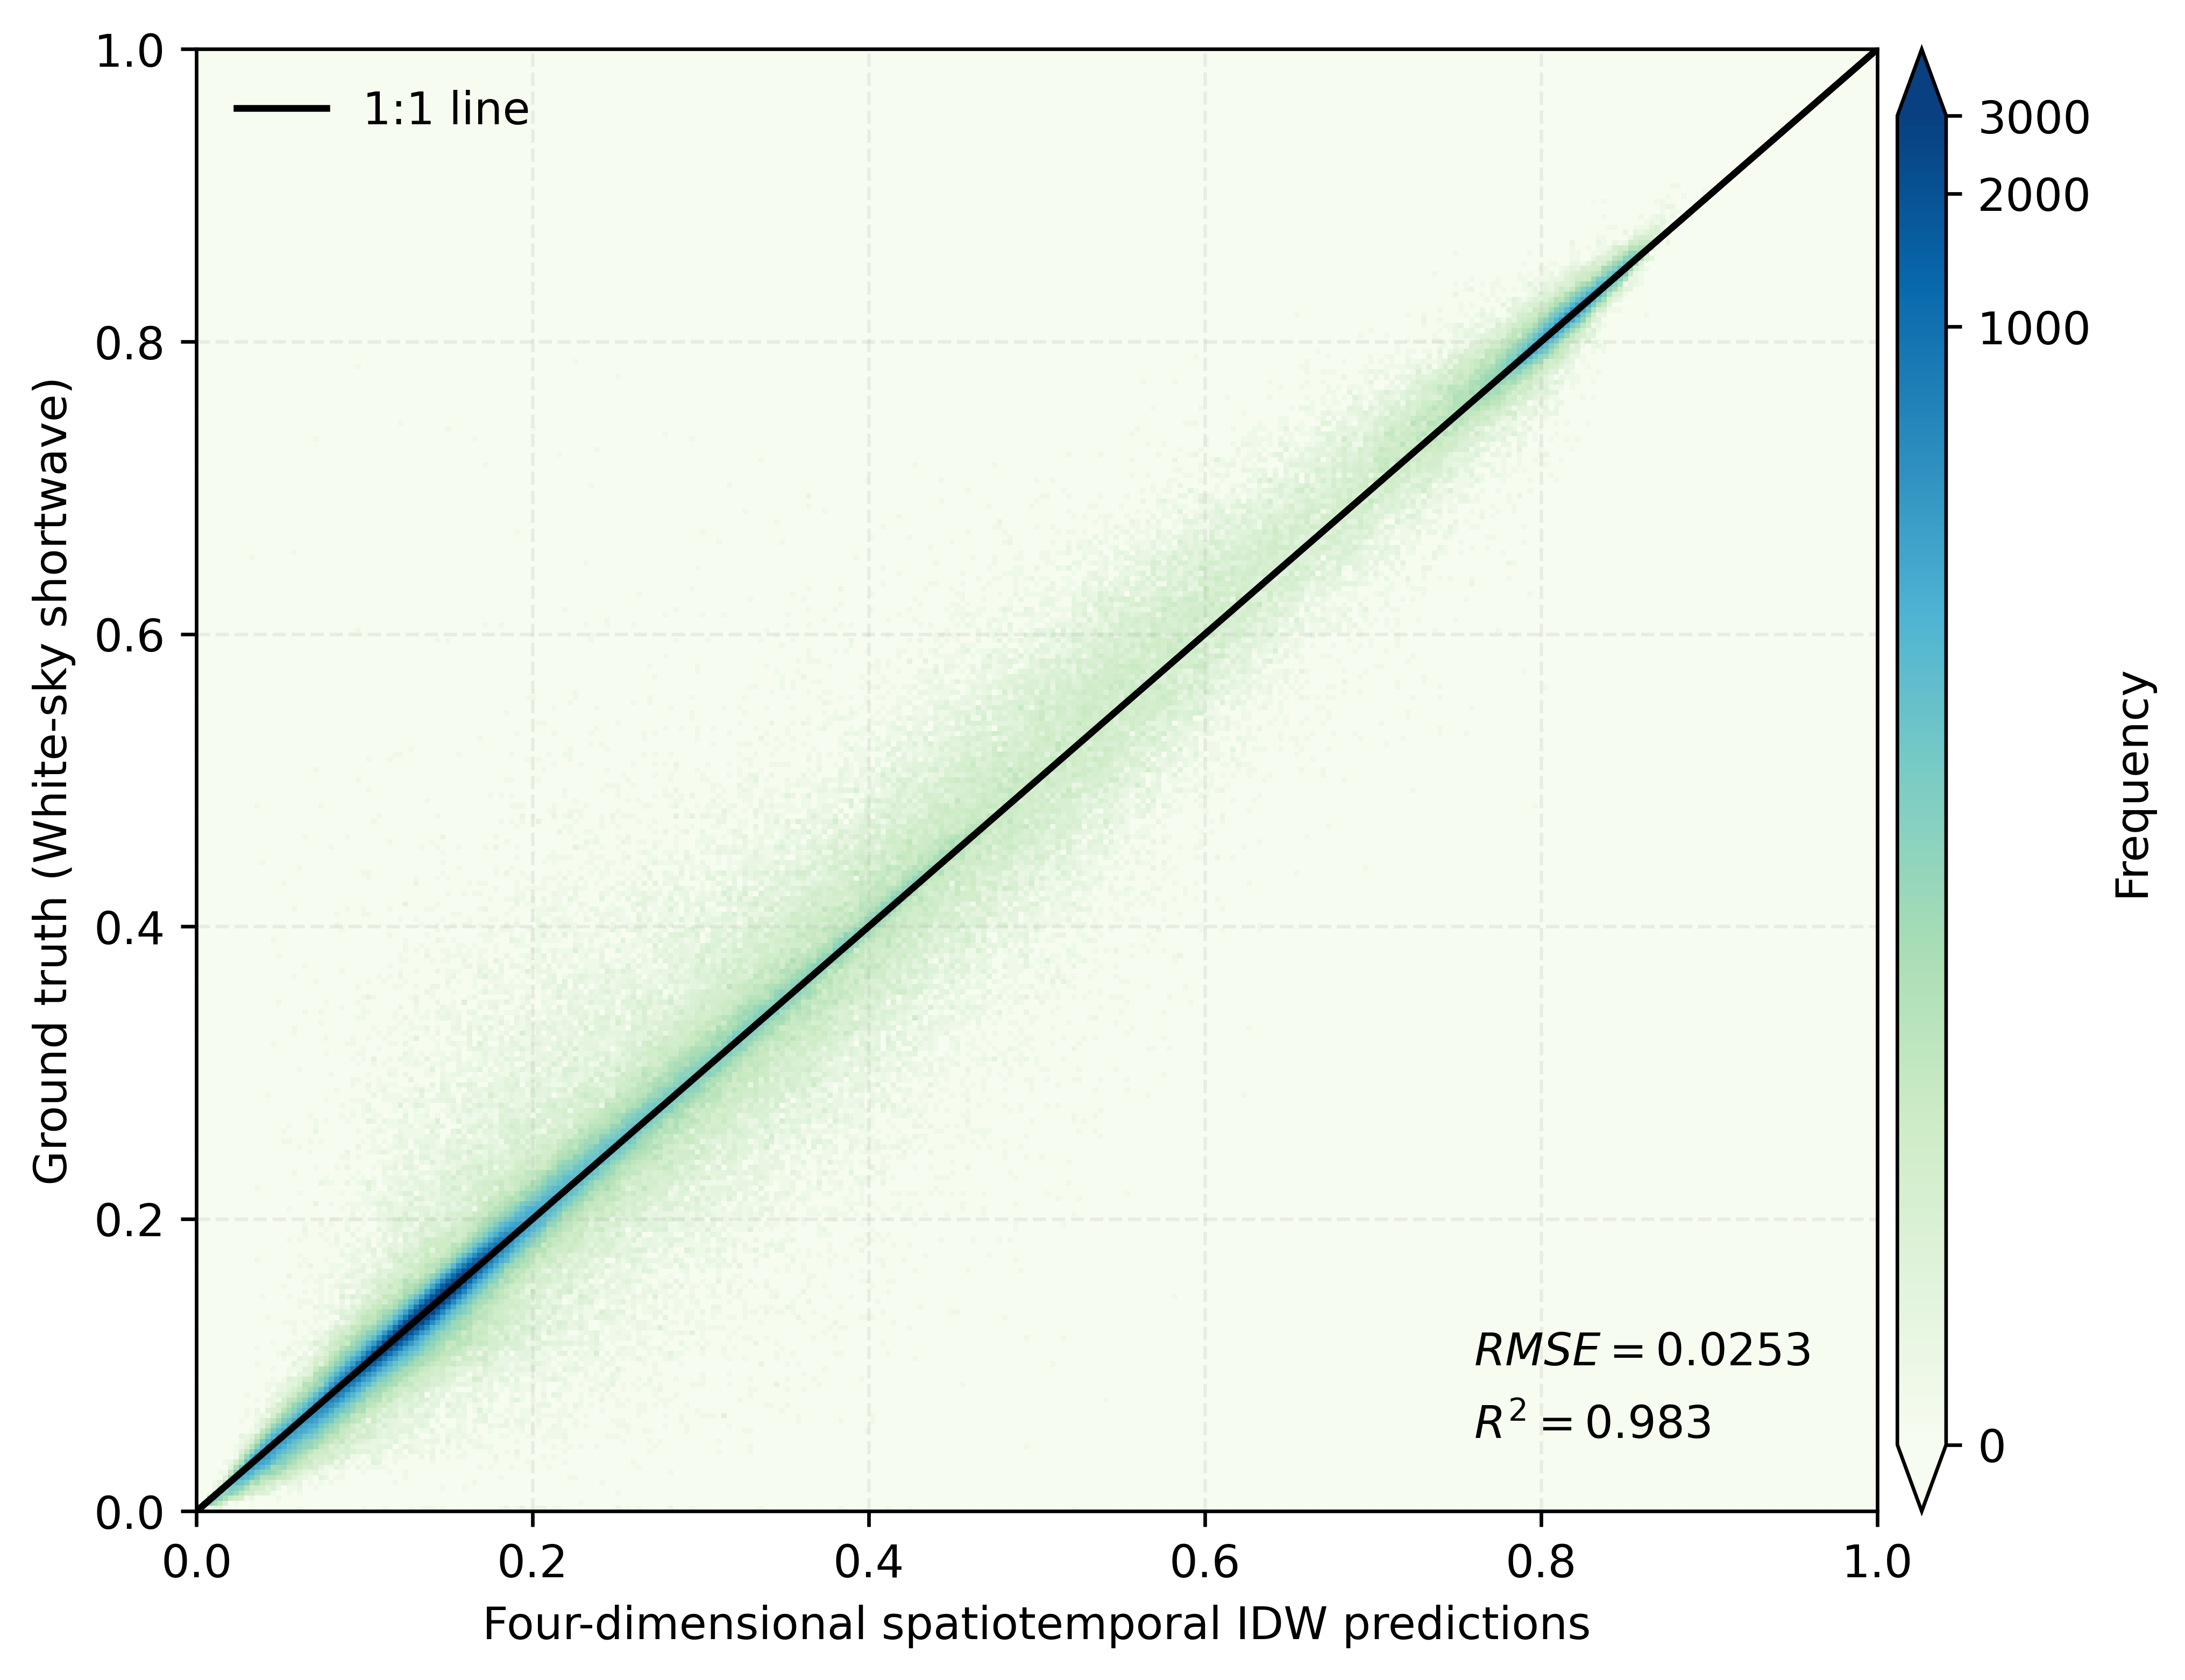

In [13]:
from statistics import mean
for iii in range(1,7):
    plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 
    x,y=np.array(aaa_pd2[f'pred_band{iii}'])/1000,np.array(aaa_pd2[f'main_band{iii}'])/1000
    R2 = r2_score(x,y)
    xy = np.vstack([x, y])
    # z=stats.gaussian_kde(xy)(xy)
    # idx=z.argsort()
    # x, y, z = x.iloc[idx], y.iloc[idx], z[idx]
    def slope(xs, ys):
        m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
        b = mean(ys) - m * mean(xs)
        return m, b
    k, b = slope(x, y)
    regression_line = []
    for a in range(100000):
        regression_line.append((k * a/100000) + b)
        
    MSE = mean_squared_error(y,x)  
    RMSE = np.power(MSE, 0.5)
    R2 = r2_score(y,x)

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    import mpl_scatter_density
    from astropy.visualization import LogStretch
    from astropy.visualization.mpl_normalize import ImageNormalize
    from matplotlib.ticker import MultipleLocator
    norm = ImageNormalize(vmin=0., vmax=3000, stretch=LogStretch())
    fig = plt.figure(figsize=(8, 6), dpi=600)
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    # scatter = ax.scatter(x, y, marker='o', c=z * 100, edgecolors=None, s=5, cmap='RdBu_r',  alpha=0.8)
    # cbar = plt.colorbar(scatter, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    density = ax.scatter_density(x, y, cmap='GnBu',norm=norm)
    cbar=fig.colorbar(density, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    cbar.ax.yaxis.set_major_locator(MultipleLocator(1000))
    plt.plot([0, 1], [0, 1], 'black', lw=1.5, label='1:1 line') 
    # plt.plot([i/100000 for i in range(100000)], regression_line, 'black', lw=1.5, label='Regression Line')  
    ax.grid(True, linestyle='--', alpha=0.2)


    plt.annotate('$R^2=%.3f$' % R2,(0.76,0.05))
    plt.annotate('$RMSE=%.4f$' % RMSE,(0.76,0.1))
    # plt.text(28,-12.5, '$R^2=%.3f$' % R2)
    # plt.text(28,-27.5, '$RMSE=%.3f$' % RMSE)
    plt.xlabel(r'Four-dimensional spatiotemporal IDW predictions',fontsize=10)
    # plt.ylabel(r'Ground truth (White-sky near-infrared)',fontsize=10)
    wb,bb=bands[iii-1].split('_')[1],bands[iii-1].split('_')[2]
    plt.ylabel(f'Ground truth ({wb} {bb})',fontsize=10)
    plt.axis([0, 1, 0,1])  # 设置线的范围
    ax.legend(loc='upper left', frameon = False)
    plt.savefig(f'./figure/IDW_{wb}_{bb}_kernel.pdf',dpi=600)
    plt.savefig(f'./figure/IDW_{wb}_{bb}_kernel.png',dpi=600)
    plt.show()

In [14]:
from tool import *
from sklearn.metrics import r2_score,mean_squared_error
kkk=pd.read_csv(root_path+f'albedo_rebuilding/rebuilding_usemean_val.csv')
kkk=kkk[kkk['rebuilding']!=0]
kkk_70=kkk[kkk.sza_L<1]
print('<70')
print('r2:',r2_score(kkk_70['truth'],kkk_70['rebuilding']))
print('rmse:',np.sqrt(mean_squared_error(kkk_70['truth'],kkk_70['rebuilding'])))

print('<85')
print('r2:',r2_score(kkk['truth'],kkk['rebuilding']))
print('rmse:',np.sqrt(mean_squared_error(kkk['truth'],kkk['rebuilding'])))

<70
r2: 0.9556866075432662
rmse: 0.05298936739095922
<85
r2: 0.9539974658468923
rmse: 0.05909415927766903


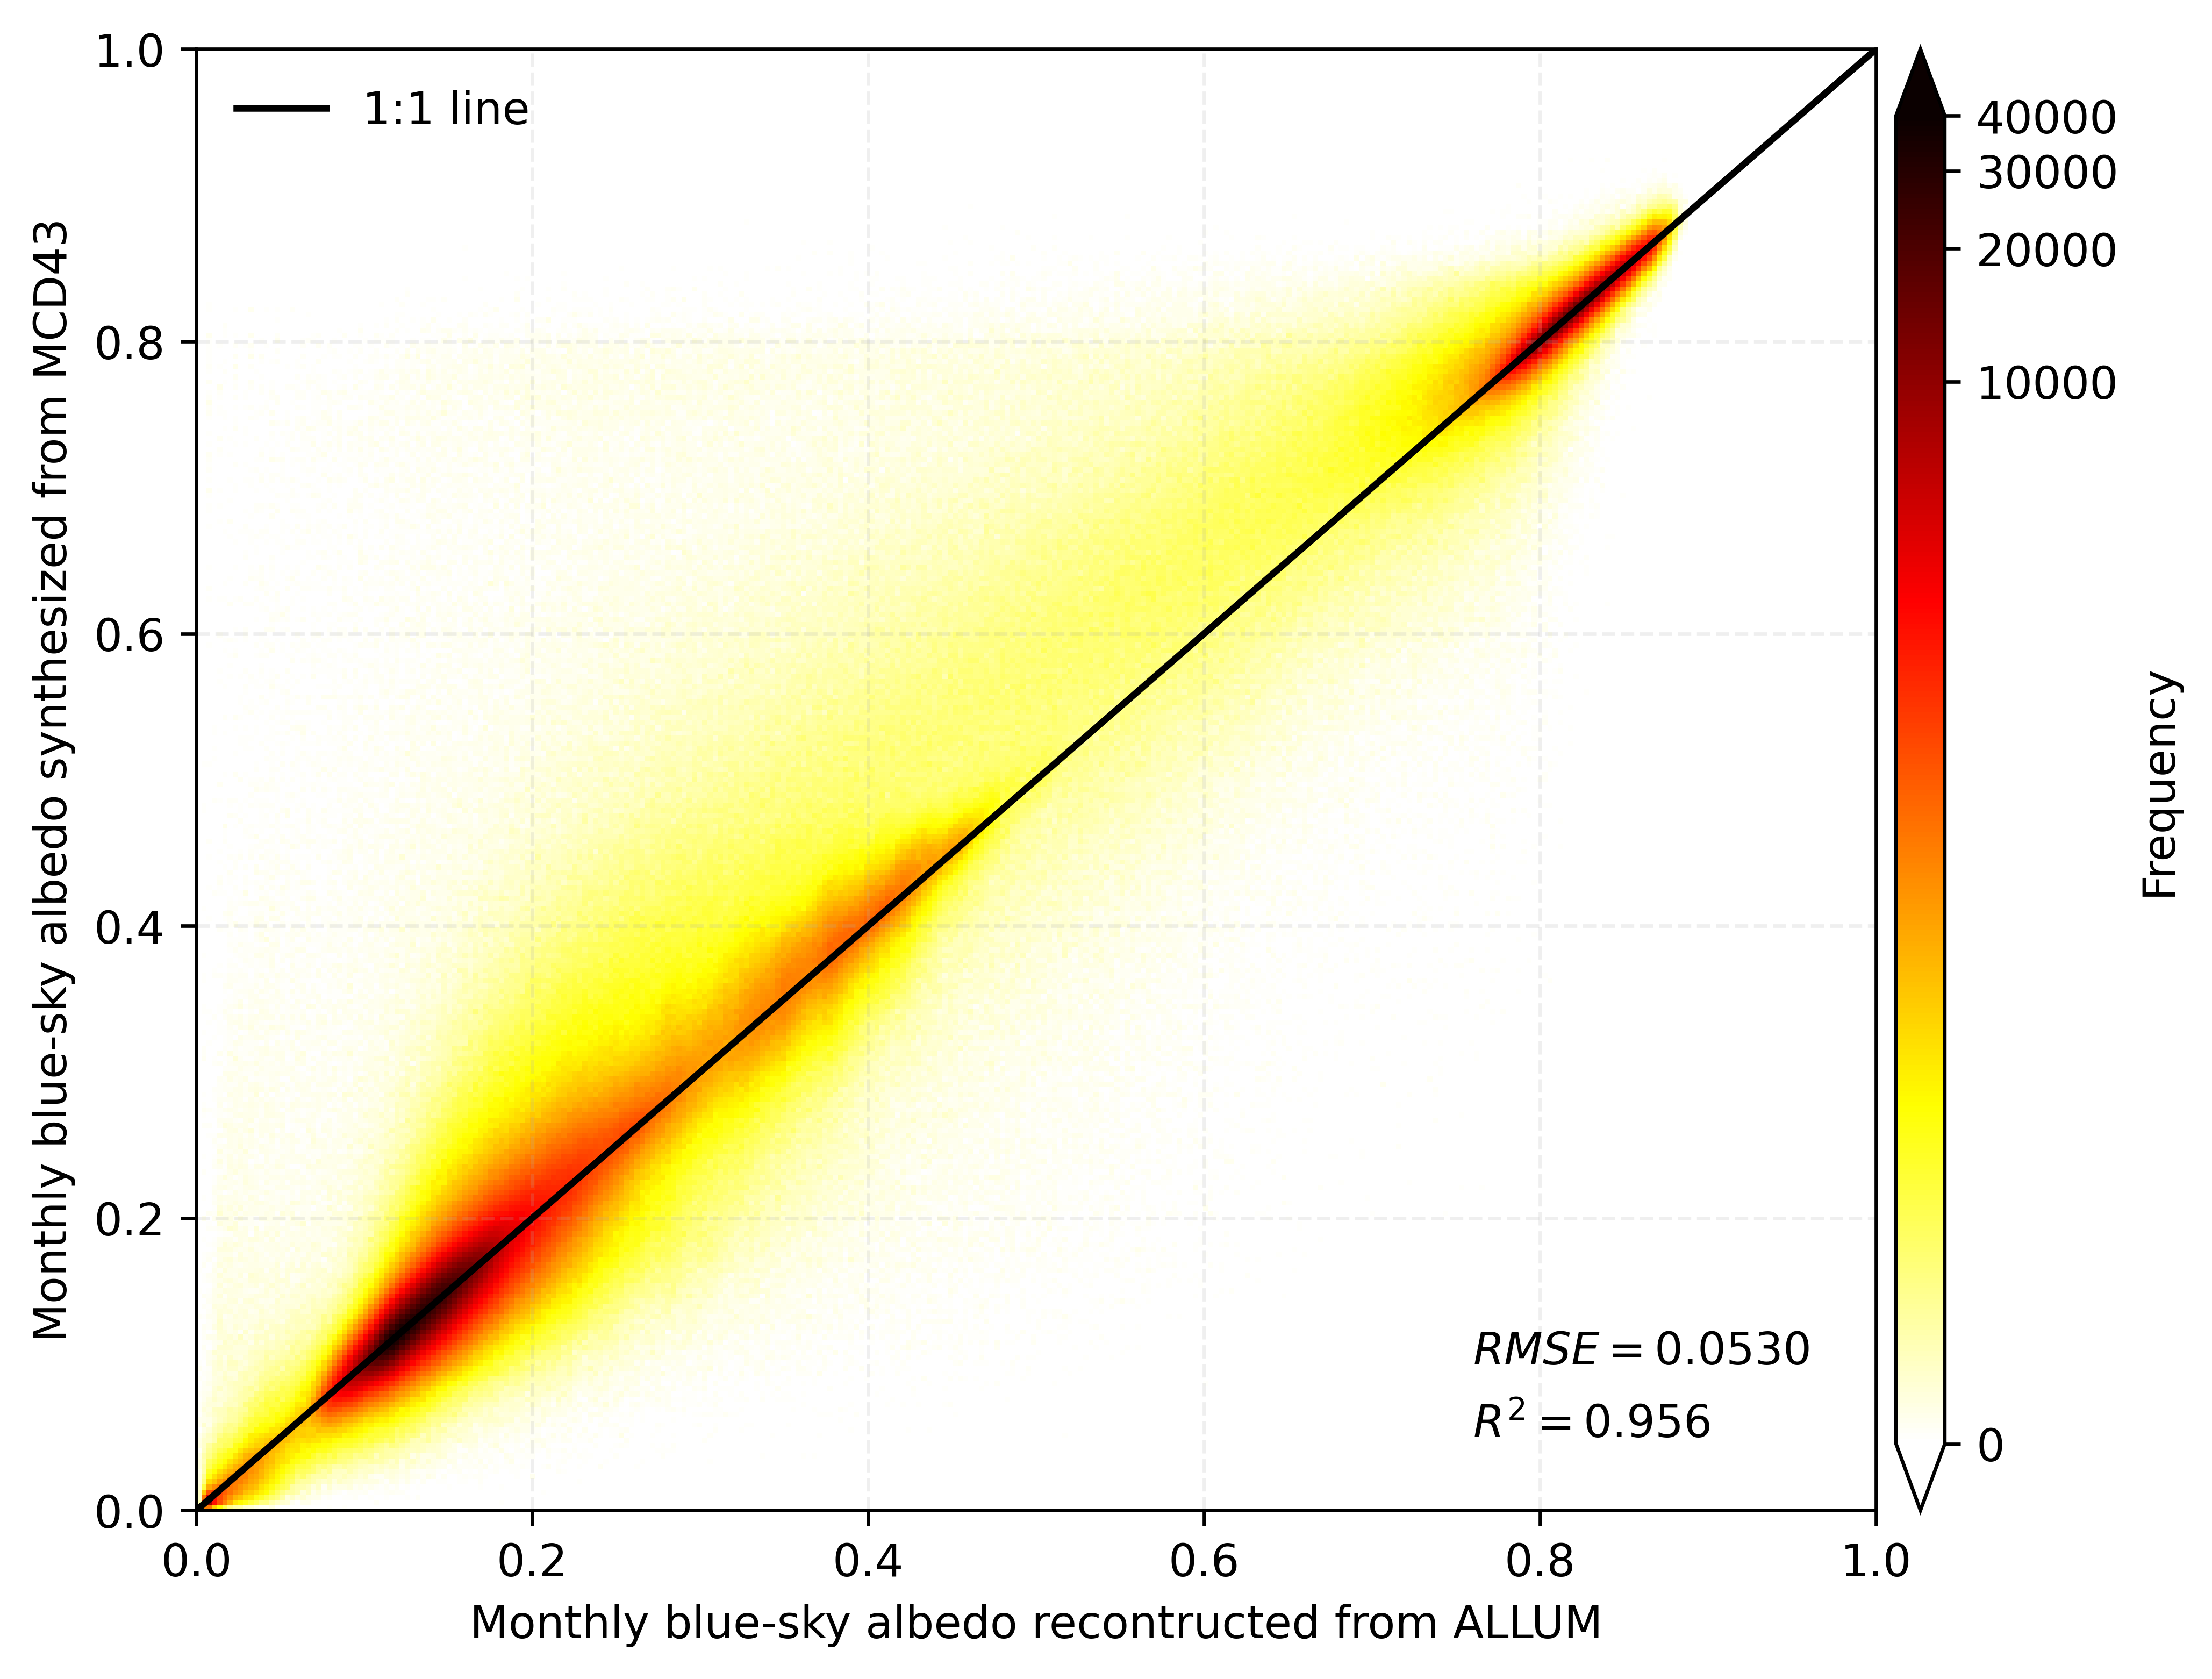

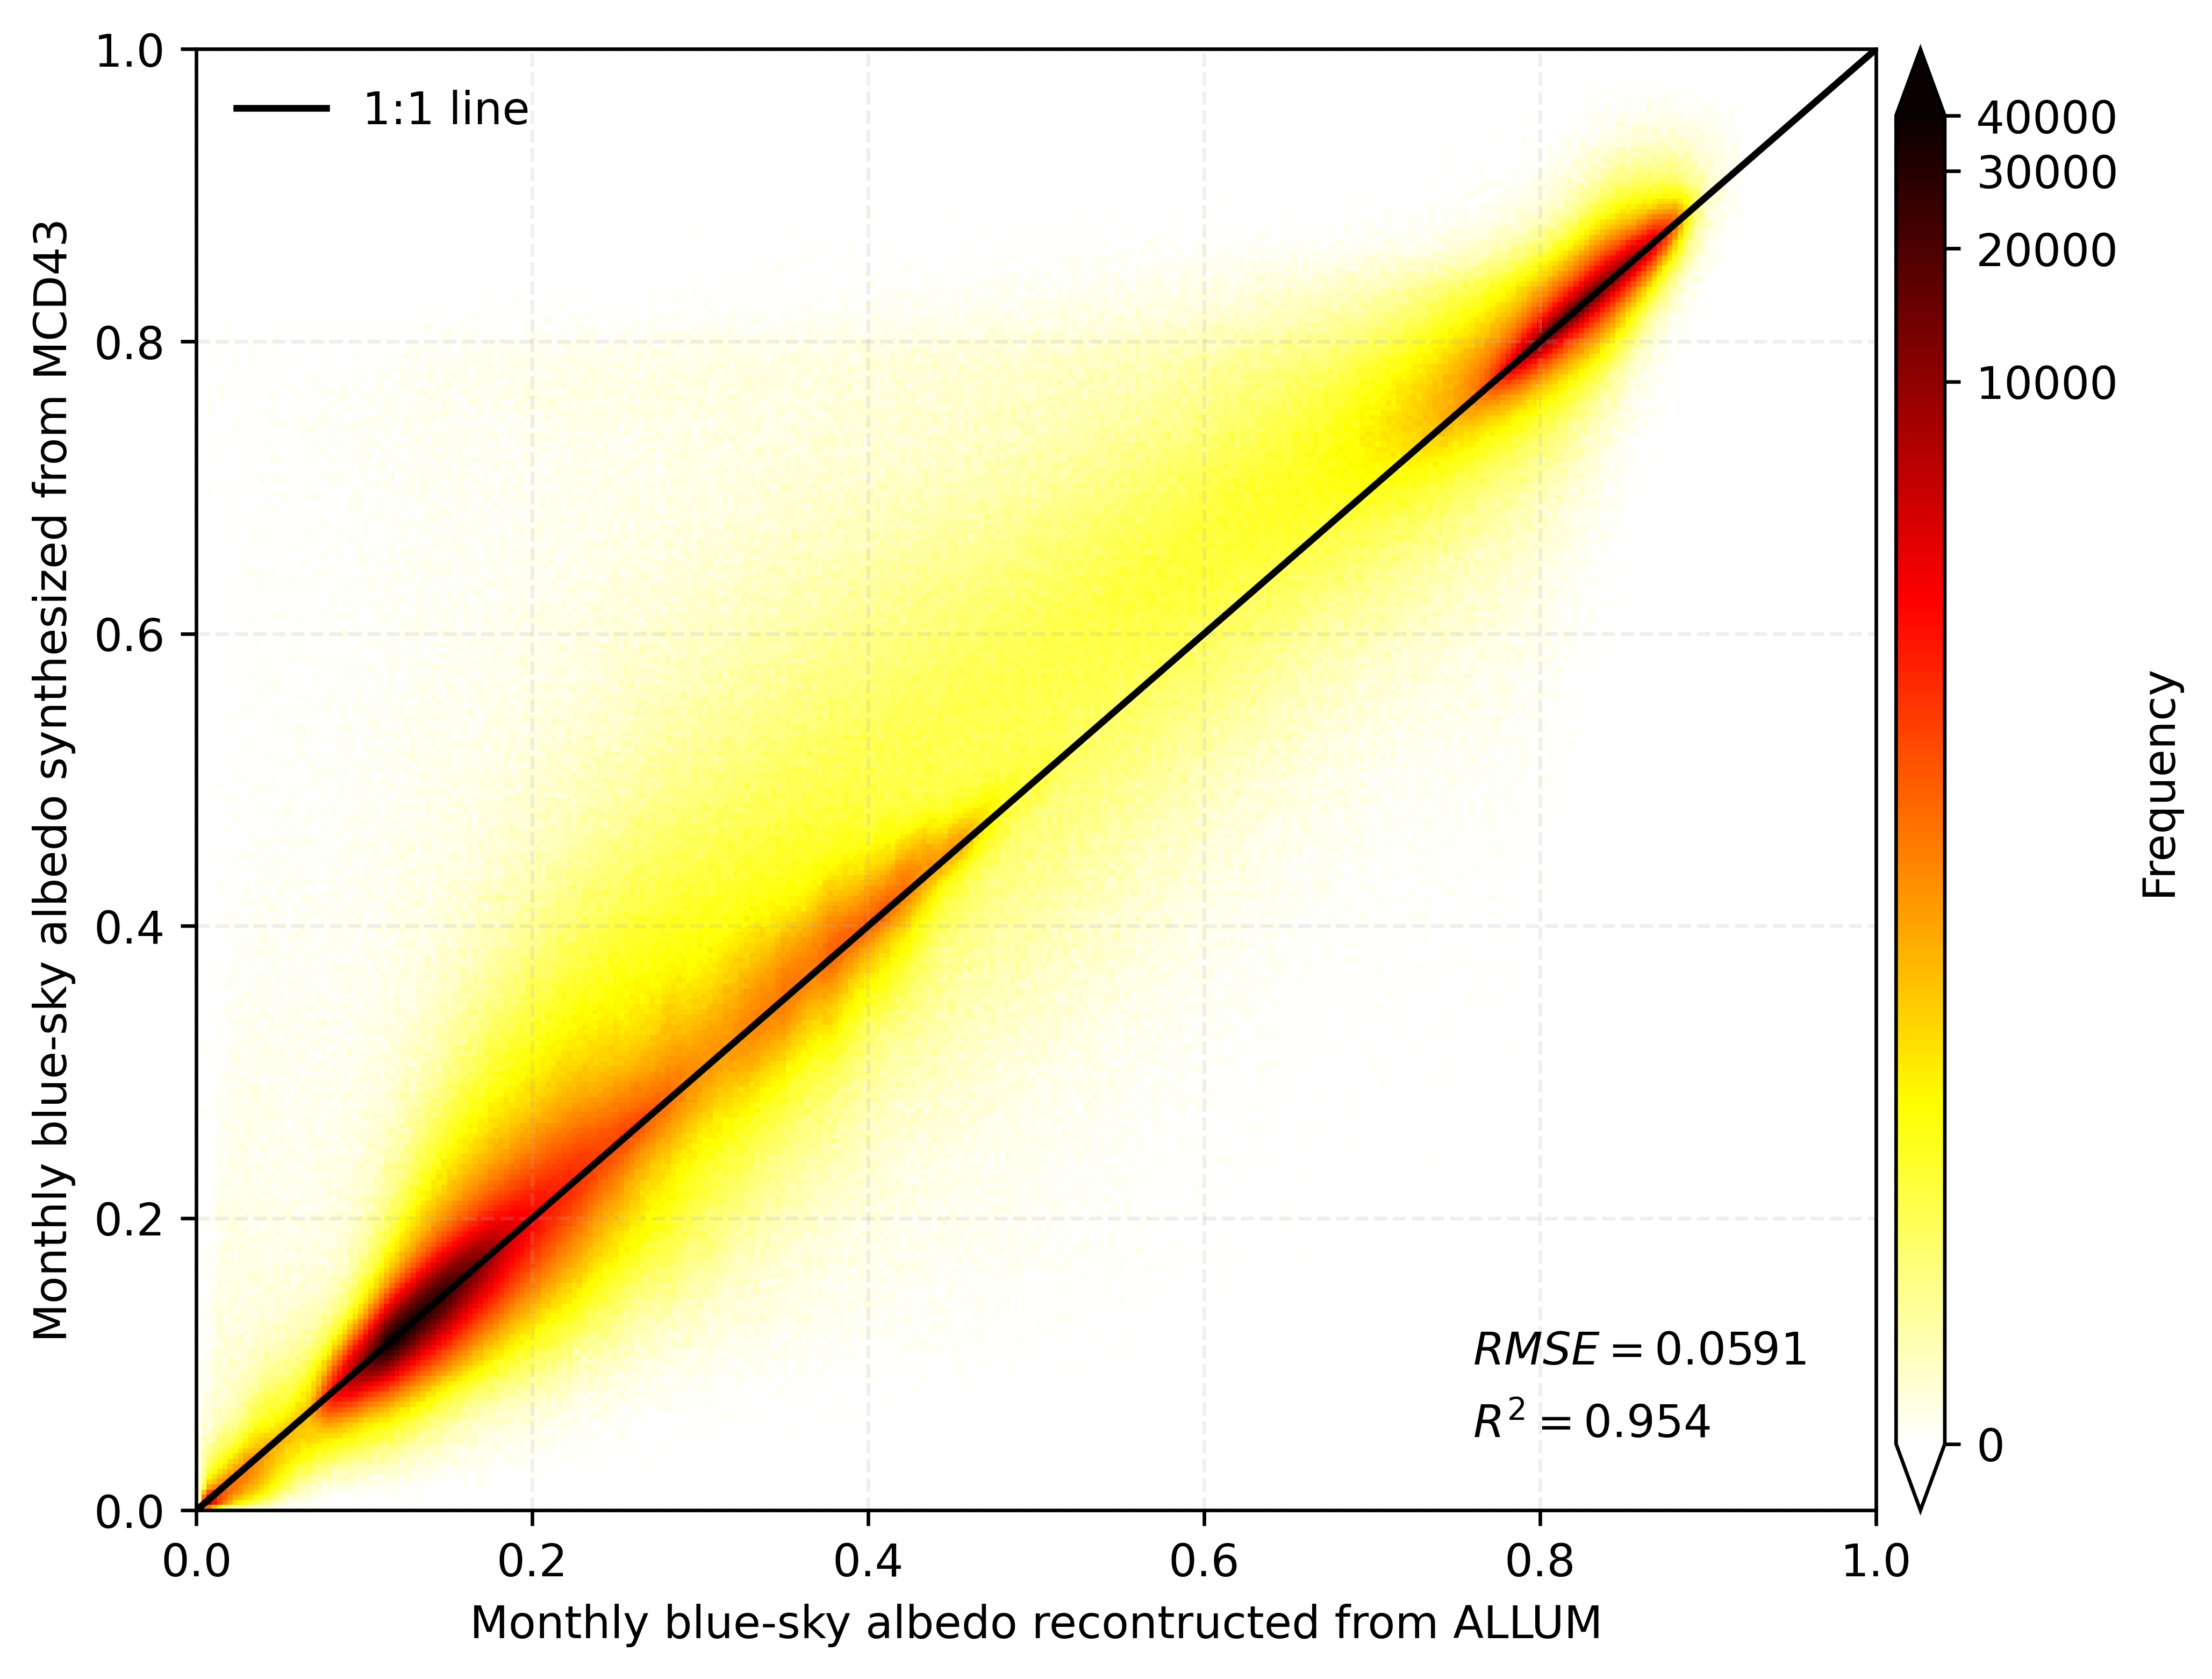

In [15]:
from scipy import  stats
from matplotlib import rcParams
from statistics import mean
from sklearn.metrics import *
from scipy.stats import pearsonr
for sza_L in [70,85]:
    if sza_L==70: 
        x,y=kkk_70['rebuilding'],kkk_70['truth']
    else:
        x,y=kkk['rebuilding'],kkk['truth']
    R2 = r2_score(x,y)
    xy = np.vstack([x, y])
    # z=stats.gaussian_kde(xy)(xy)
    # idx=z.argsort()
    # x, y, z = x.iloc[idx], y.iloc[idx], z[idx]
    def slope(xs, ys):
        m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
        b = mean(ys) - m * mean(xs)
        return m, b
    k, b = slope(x, y)
    regression_line = []
    for a in range(100000):
        regression_line.append((k * a/100000) + b)
        
    MSE = mean_squared_error(y,x)  
    RMSE = np.power(MSE, 0.5)
    R2 = r2_score(y,x)

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    import mpl_scatter_density
    from astropy.visualization import LogStretch
    from astropy.visualization.mpl_normalize import ImageNormalize
    from matplotlib.ticker import MultipleLocator
    norm = ImageNormalize(vmin=0., vmax=40000, stretch=LogStretch())
    fig = plt.figure(figsize=(8, 6), dpi=600)
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    # scatter = ax.scatter(x, y, marker='o', c=z * 100, edgecolors=None, s=5, cmap='RdBu_r',  alpha=0.8)
    # cbar = plt.colorbar(scatter, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    density = ax.scatter_density(x, y, cmap='hot_r',norm=norm)
    cbar=fig.colorbar(density, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    cbar.ax.yaxis.set_major_locator(MultipleLocator(10000))
    plt.plot([0, 1], [0, 1], 'black', lw=1.5, label='1:1 line') 
    # plt.plot([i/100000 for i in range(100000)], regression_line, 'black', lw=1.5, label='Regression Line')  
    ax.grid(True, linestyle='--', alpha=0.2)


    plt.annotate('$R^2=%.3f$' % R2,(0.76,0.05))
    plt.annotate('$RMSE=%.4f$' % RMSE,(0.76,0.1))
    # plt.text(28,-12.5, '$R^2=%.3f$' % R2)
    # plt.text(28,-27.5, '$RMSE=%.3f$' % RMSE)
    plt.xlabel(r'Monthly blue-sky albedo recontructed from ALLUM',fontsize=10)
    plt.ylabel(r'Monthly blue-sky albedo synthesized from MCD43',fontsize=10)
    plt.axis([0, 1, 0,1])  # 设置线的范围
    ax.legend(loc='upper left', frameon = False)
    plt.savefig(f'./figure/rebuilding500_{sza_L}_val_kernel.pdf',dpi=600)
    plt.savefig(f'./figure/rebuilding500_{sza_L}_val_kernel.png',dpi=600)
    plt.show()

In [7]:
rr70=[]
mm70=[]
for m in range(1,13):
    kkk1=kkk_70[kkk_70['month']==m]
    rr70.append(r2_score(kkk1['truth'],kkk1['rebuilding']))
    mm70.append(np.sqrt(mean_squared_error(kkk1['truth'],kkk1['rebuilding'])))
rr85=[]
mm85=[]
for m in range(1,13):
    kkk1=kkk[kkk['month']==m]
    rr85.append(r2_score(kkk1['truth'],kkk1['rebuilding']))
    mm85.append(np.sqrt(mean_squared_error(kkk1['truth'],kkk1['rebuilding'])))

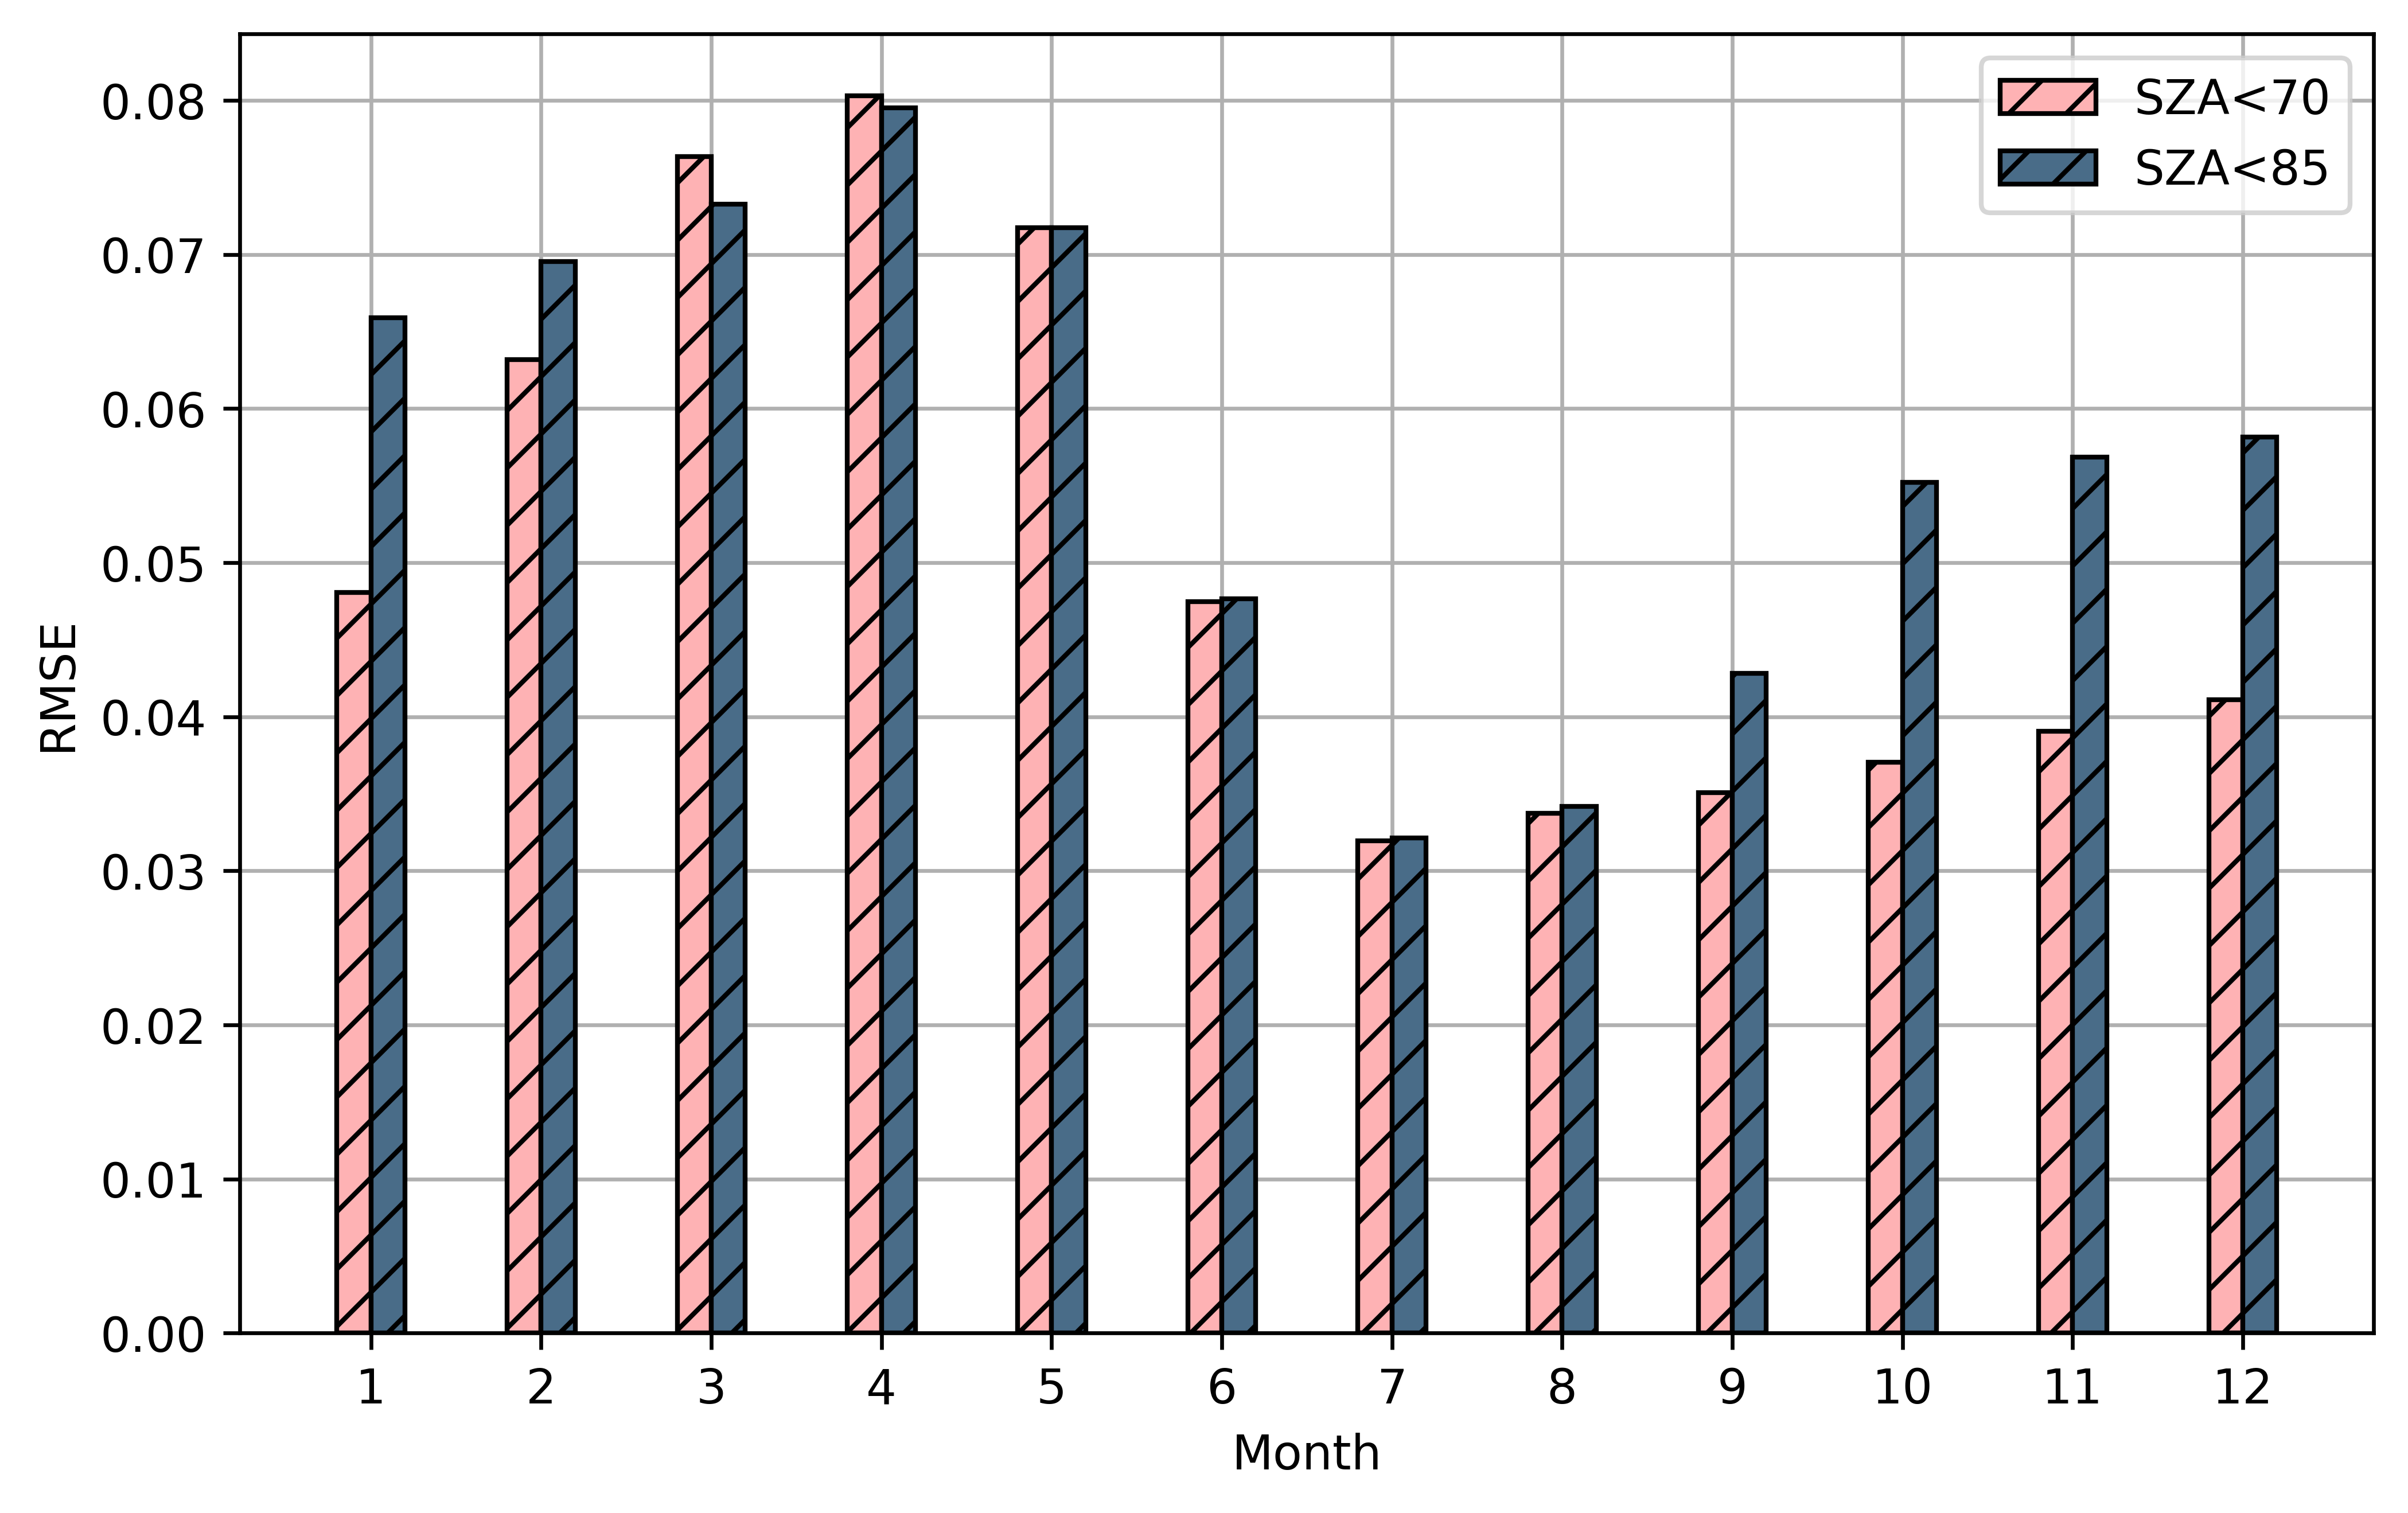

In [15]:
plt.figure(figsize=(8,5),dpi=600)
width = 0.2
x = np.arange(1,13)-width/2
x2=x+width
plt.grid(b=None, which='major',zorder=0 )
plt.bar(x,mm70,width=width,color='#FEB2B4',edgecolor='black',label='SZA<70', zorder=100,hatch='//')
plt.bar(x2,mm85,width=width,color='#496C88',edgecolor='black',label='SZA<85', zorder=100,hatch='//')
plt.xlabel(r'Month')
plt.ylabel(r'RMSE')
plt.xticks(range(1,13))
plt.legend()
plt.savefig('./figure/rebuilding500_RMSE.pdf',dpi=600)
plt.savefig('./figure/rebuilding500_RMSE.png',dpi=600)
plt.show()

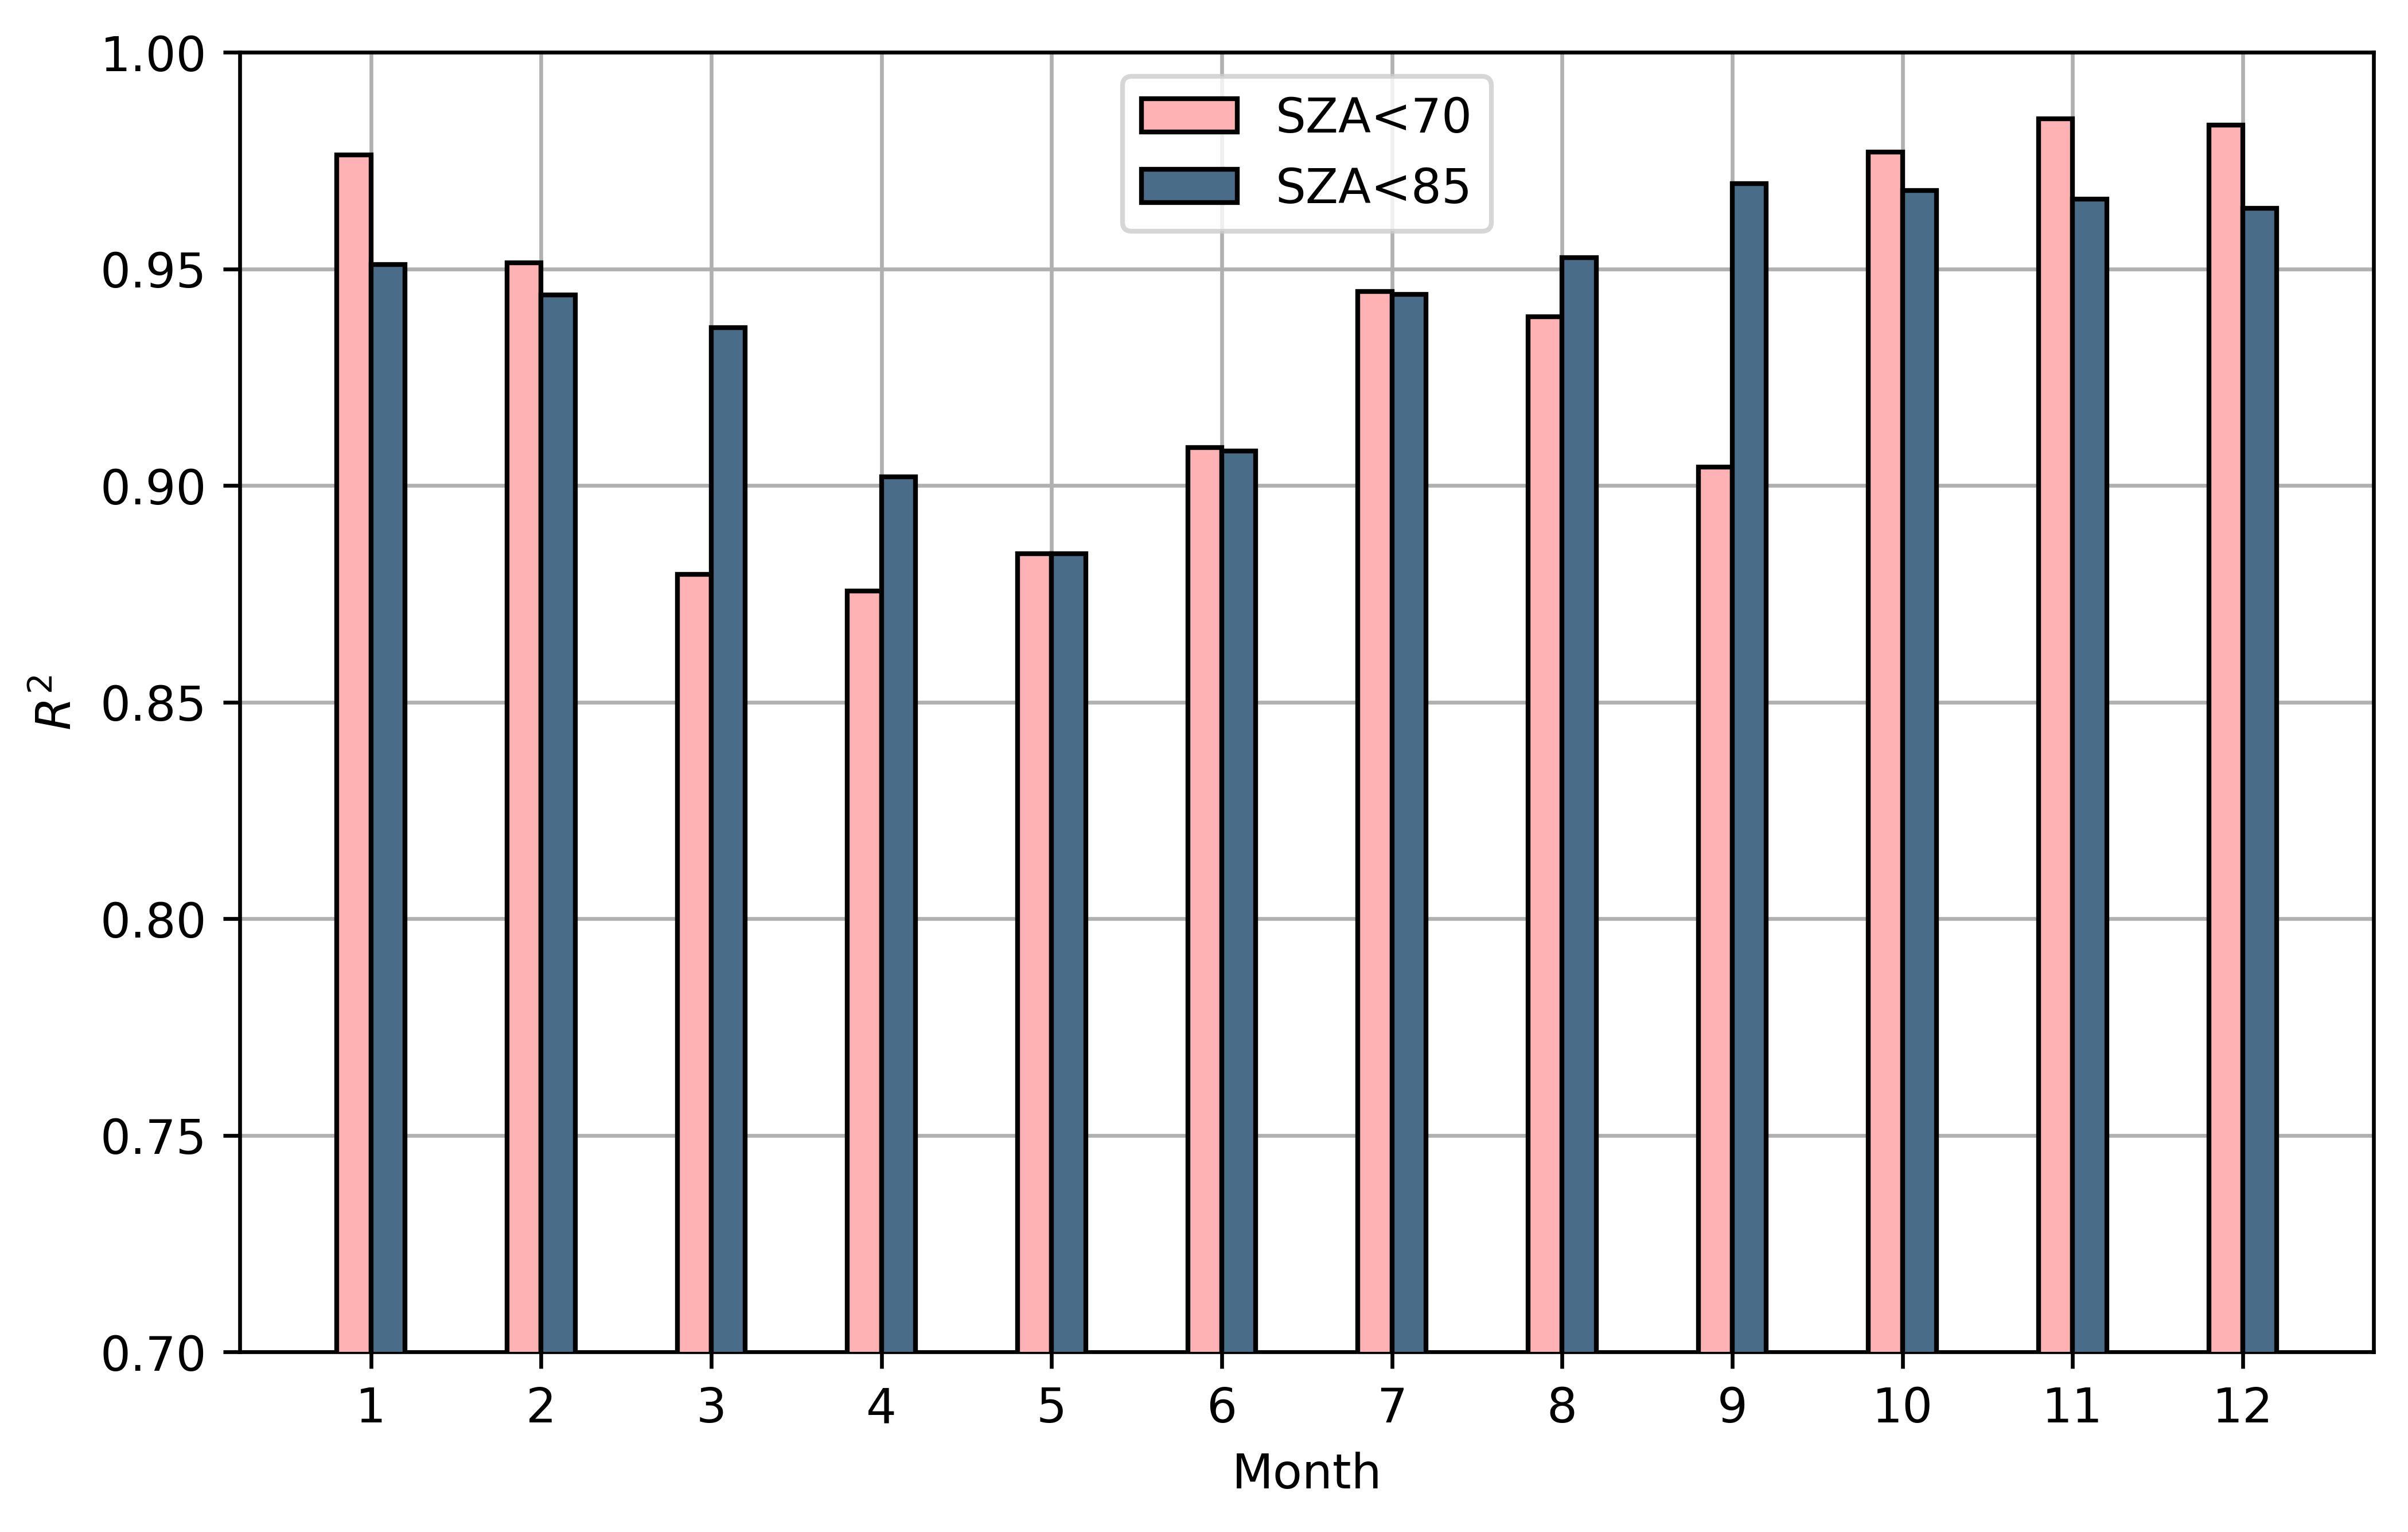

In [16]:
plt.figure(figsize=(8,5),dpi=600)
width = 0.2
x = np.arange(1,13)-width/2
x2=x+width
plt.grid(b=None, which='major',zorder=0 )
plt.bar(x,rr70,width=width,color='#FEB2B4',edgecolor='black',label='SZA<70', zorder=100)
plt.bar(x2,rr85,width=width,color='#496C88',edgecolor='black',label='SZA<85', zorder=100)
plt.ylim(0.7,1)
plt.xlabel(r'Month',)
plt.ylabel(r'$R^2$')
plt.xticks(range(1,13))
plt.legend()
plt.savefig('./figure/rebuilding500_R2.pdf',dpi=600)
plt.savefig('./figure/rebuilding500_png.pdf',dpi=600)
plt.show()

In [16]:
pdd=pd.read_csv('model_val/all.csv')
ww=pdd[pdd['w/b-sky']=='W']
bb=pdd[pdd['w/b-sky']=='B']
print('White-sky')
print('r2:',r2_score(ww['gt']/1000,ww['pre']/1000))
print('rmse:',np.sqrt(mean_squared_error(ww['gt']/1000,ww['pre']/1000)))
print('Black-sky')
print('r2:',r2_score(bb['gt']/1000,bb['pre']/1000))
print('rmse:',np.sqrt(mean_squared_error(bb['gt']/1000,bb['pre']/1000)))

White-sky
r2: 0.9311760376968371
rmse: 0.010165926522237906
Black-sky
r2: 0.9431448464143906
rmse: 0.009010601434511127


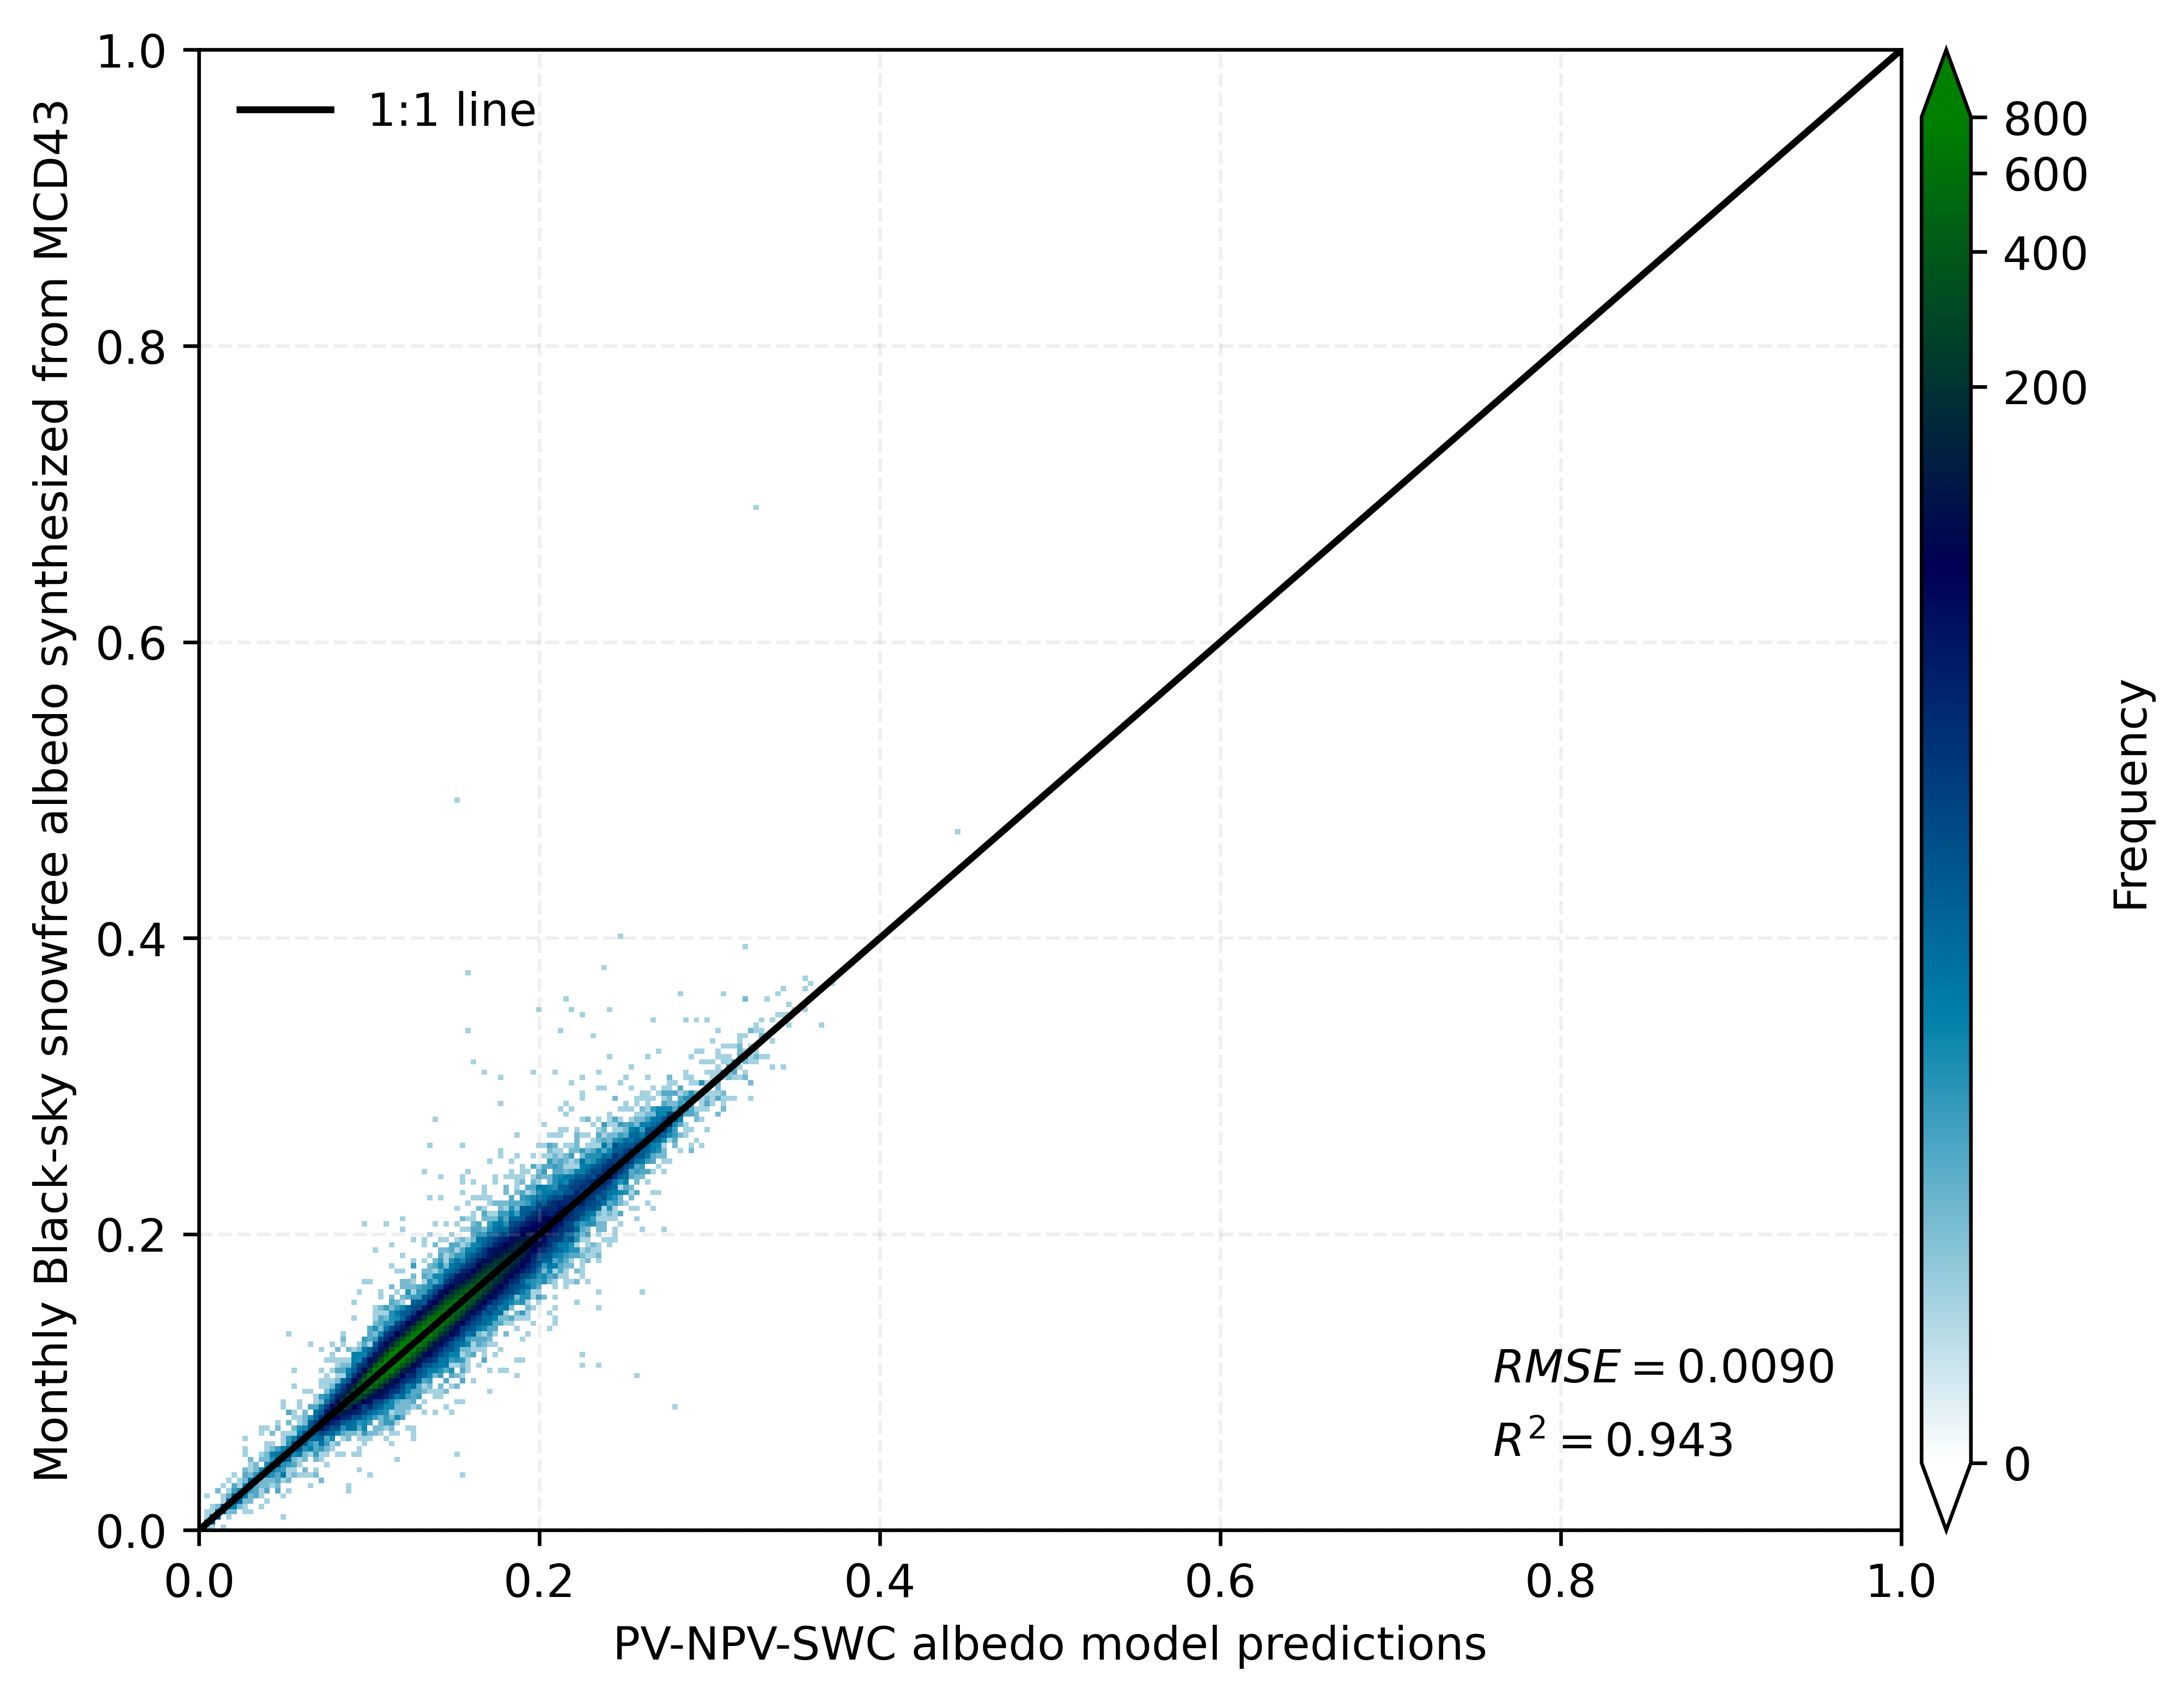

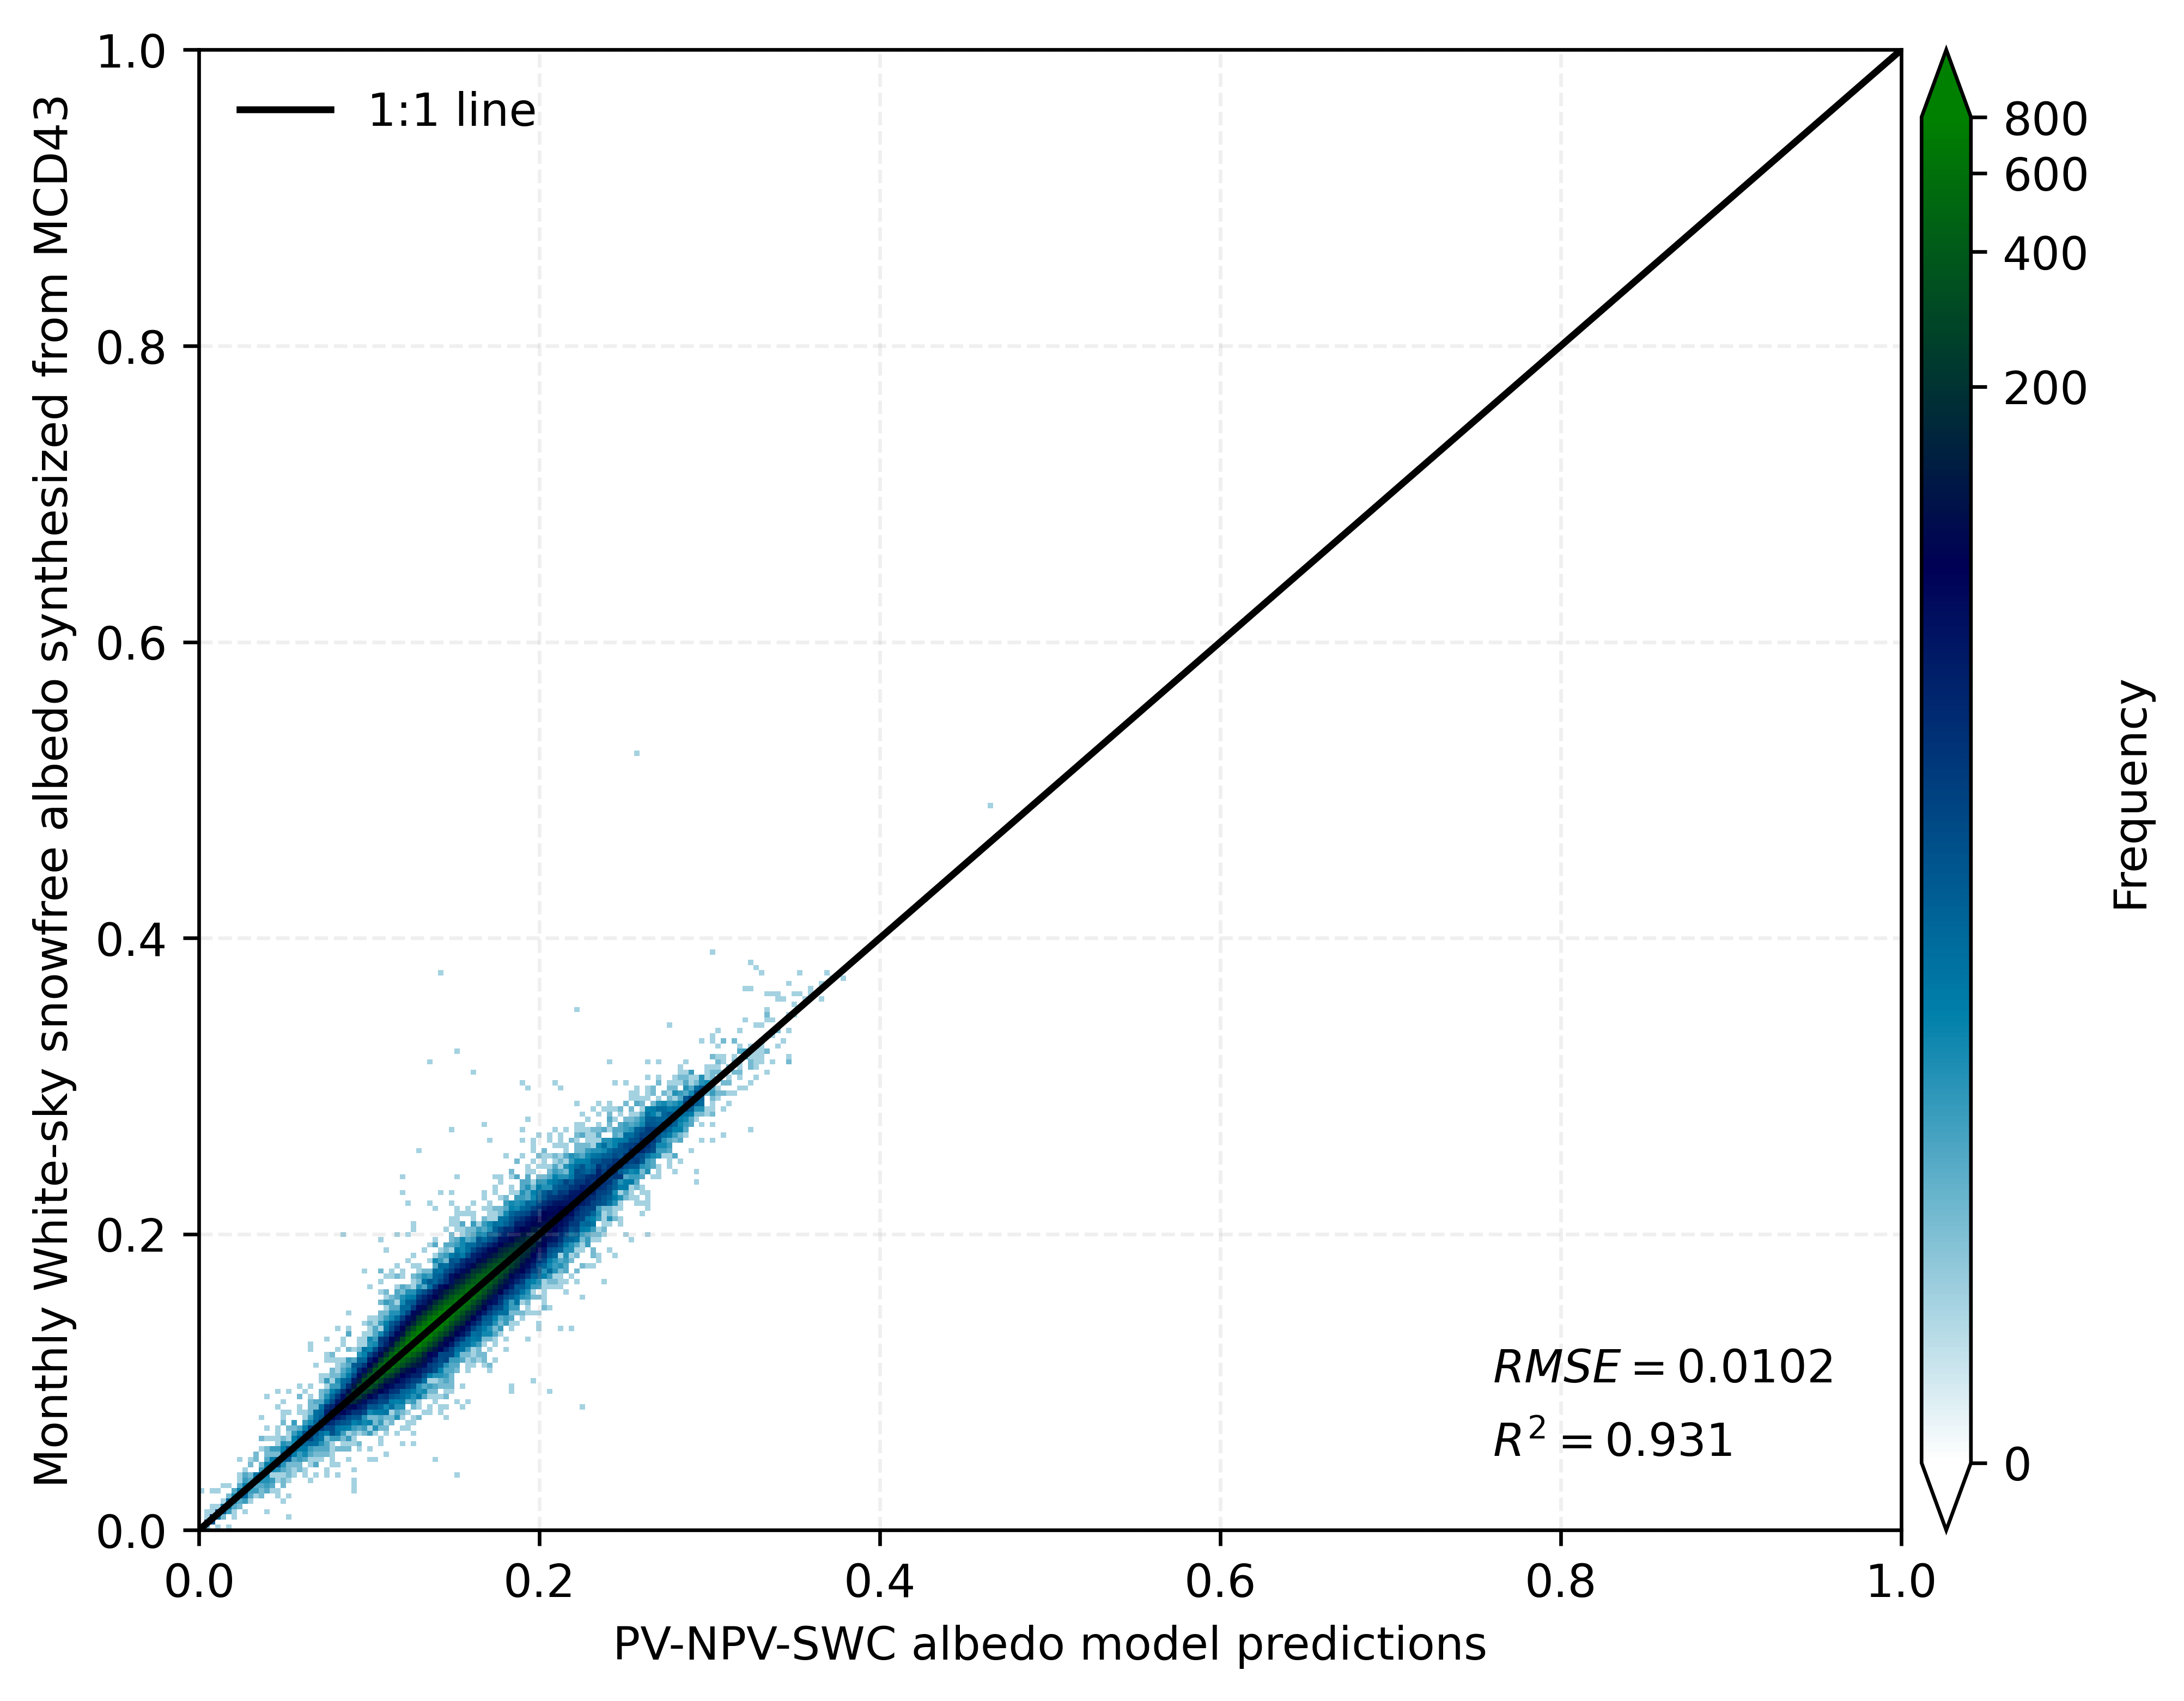

In [17]:
for wb_sky in ['B','W']:
    pdd_wb=pdd[pdd['w/b-sky']==wb_sky]

    x,y=pdd_wb['pre']/1000,pdd_wb['gt']/1000

    R2 = r2_score(x,y)
    xy = np.vstack([x, y])
    # z=stats.gaussian_kde(xy)(xy)
    # idx=z.argsort()
    # x, y, z = x.iloc[idx], y.iloc[idx], z[idx]
    def slope(xs, ys):
        m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
        b = mean(ys) - m * mean(xs)
        return m, b
    k, b = slope(x, y)
    regression_line = []
    for a in range(100000):
        regression_line.append((k * a/100000) + b)
        
    MSE = mean_squared_error(y,x)  
    RMSE = np.power(MSE, 0.5)
    R2 = r2_score(y,x)

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    import mpl_scatter_density
    from astropy.visualization import LogStretch
    from astropy.visualization.mpl_normalize import ImageNormalize
    from matplotlib.ticker import MultipleLocator
    norm = ImageNormalize(vmin=0., vmax=800, stretch=LogStretch())
    fig = plt.figure(figsize=(8, 6), dpi=600)
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    plt.plot([0, 1], [0, 1], 'black', lw=1.5, label='1:1 line') 
    # plt.plot([i/100000 for i in range(100000)], regression_line, 'black', lw=1.5, label='Regression Line') 
    # scatter = ax.scatter(x, y, marker='o', c=z * 100, edgecolors=None, s=5, cmap='RdBu_r',  alpha=0.8)
    # cbar = plt.colorbar(scatter, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    density = ax.scatter_density(x, y, cmap='ocean_r',norm=norm)
    cbar=fig.colorbar(density, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    cbar.ax.yaxis.set_major_locator(MultipleLocator(200))
 
    ax.grid(True, linestyle='--', alpha=0.2)


    plt.annotate('$R^2=%.3f$' % R2,(0.76,0.05))
    plt.annotate('$RMSE=%.4f$' % RMSE,(0.76,0.1))
    # plt.text(28,-12.5, '$R^2=%.3f$' % R2)
    # plt.text(28,-27.5, '$RMSE=%.3f$' % RMSE)
    if wb_sky=='W':
        zzzz='White'
    else:
        zzzz='Black'
    plt.xlabel(f'PV-NPV-SWC albedo model predictions',fontsize=10)
    plt.ylabel(f'Monthly {zzzz}-sky snowfree albedo synthesized from MCD43',fontsize=10)
    plt.axis([0, 1, 0,1])  # 设置线的范围
    ax.legend(loc='upper left', frameon = False)
    plt.savefig(f'./figure/albedomodel_{wb_sky}_val_kernel.pdf',dpi=600)
    plt.savefig(f'./figure/albedomodel_{wb_sky}_val_kernel.png',dpi=600)
    plt.show()

In [35]:
from scipy import stats
import numpy as np
def t_test(a,b):
    if len(a.shape)==1:
        a=a.reshape((1,-1))
    if len(b.shape)==1:
        b=b.reshape((1,-1))
    def t_test_single(a_single,b_single):
        r=stats.ttest_ind(a_single, b_single)
        # return [r.__getattribute__("statistic"),r.__getattribute__("pvalue")]
        return [(r.__getattribute__("statistic")>0).astype(np.int8),(r.__getattribute__("pvalue")<0.05).astype(np.int8)]
    k=[t_test_single(a[i],b[i]) for i in range(a.shape[0])]
    k2=[k[i][0] for i in range(len(k))]
    k3=[k[i][1] for i in range(len(k))]
    return [k2,k3]

In [1]:
from tool import *
mt=[]
for month in range(1,13):
    now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
    month_time=(now+relativedelta(months=1)-now).total_seconds()
    mt.append(month_time)
mt=np.array(mt)


def month_fill(data,mask):
    data_mean=np.nanmean(data,axis=0)
    for i in range(12):
        data[i][mask[i]]=data_mean[mask[i]]
    return data
from tool import *
stat=torch.load(f'/data/hk/albedo/stat_sw-mean_sza-70_band-shortwave_kernel.pth')
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')


albedo_all=np.zeros((12,20,18,180,360)).astype(np.float32)
area_all=np.zeros((12,20,18,180,360)).astype(np.float32)
mask=np.zeros((12,20,18,180,360))

for y in range(2001,2021):
    for m in range(1,13):
        albedo_all[m-1,y-2001]=stat[f'{y}-{m}-albedo']
        area_all[m-1,y-2001]=stat[f'{y}-{m}-typearea']
        mask[m-1,y-2001]=np.expand_dims(sza_L[y-2001,m-1],0).repeat(18,axis=0)
# albedo_all=month_fill(albedo_all,mask>=1)
albedo_all[albedo_all==0]=np.nan
albedo_all[mask>=1]=np.nan
area_all=month_fill(area_all,mask>=1)
albedo_all=month_fill(albedo_all,mask>=1)


In [2]:
def get_sequence_map(mode):
    def filter_mode(data,mode):
        if mode=='snowfree':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
        elif mode=='all':
            pass
        elif mode=='snow':
            data[:,:,:,:-1,:-1]=0
        elif mode=='conversion':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
            for i in range(18):
                data[:,:,:,i,i]=0       
        elif mode=='non_conversion':
            mask_filter=np.zeros((18,18))
            for i in range(17):
                mask_filter[i,i]=1
            data=data*(mask_filter.reshape((1,1,1,18,18)))
        else:
            raise('ERROR MODE')
        return data
            
    data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
    mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
    data_m[mask_t>=1]=np.nan
    data_m=month_fill(data_m,mask_t>=1)
    if mode in ['snow','conversion','non_conversion']:
        data_m2=data_m.copy()
    data_m=filter_mode(data_m,mode)
    z=albedo_all[:,0].transpose((0,2,3,1)).reshape((12,180,360,18,1))*data_m
    z[np.isnan(z)]=0
    z=z*(mt.reshape(12,1,1,1,1)/365/24/3600)
    z=z.transpose((1,2,3,4,0))
    for i in range(3):
        z=np.nansum(z,axis=-1)
        
    if mode in ['snow','conversion','non_conversion']:
        data_m=data_m2
    data_m=np.nanmean(data_m,axis=0)
    data_m=np.nansum(data_m,axis=-1)
    data_m=np.nansum(data_m,axis=-1)
    kkk=[z/data_m]


    for y in tqdm(range(2002,2021)):
        data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_{y}.pth')
        mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
        data_m[mask_t>=1]=np.nan
        data_m=month_fill(data_m,mask_t>=1)
        if mode in ['snow','conversion','non_conversion']:
            data_m2=data_m.copy()
        data_m=filter_mode(data_m,mode)
        z=albedo_all[:,y-2001].transpose((0,2,3,1)).reshape((12,180,360,1,18))*data_m
        z[np.isnan(z)]=0
        z=z*(mt.reshape(12,1,1,1,1)/365/24/3600)
        z=z.transpose((1,2,3,4,0))
        for i in range(3):
            z=np.nansum(z,axis=-1)
            
        if mode in ['snow','conversion','non_conversion']:
            data_m=data_m2
        data_m=np.nanmean(data_m,axis=0)
        data_m=np.nansum(data_m,axis=-1)
        data_m=np.nansum(data_m,axis=-1)
        kkk+=[z/data_m]
    return kkk

# np.nansum(z[:,24:90-23])/np.nansum(np.nanmean(data_m[:,24:90-23],axis=0))

100%|██████████| 19/19 [01:38<00:00,  5.18s/it]


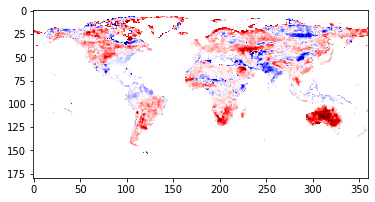

In [23]:
kkk_snowfree=get_sequence_map('snowfree')
plt.imshow(kkk_snowfree[-1]-kkk_snowfree[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [01:36<00:00,  5.09s/it]


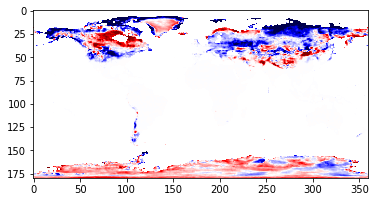

In [ ]:
kkk_snow=get_sequence_map('snow')
plt.imshow(kkk_snow[-1]-kkk_snow[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [01:38<00:00,  5.19s/it]


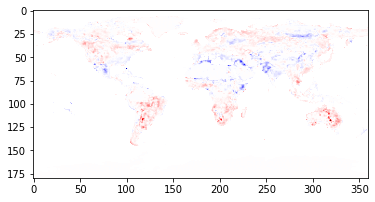

In [ ]:
kkk_conversion=get_sequence_map('conversion')
plt.imshow(kkk_conversion[-1]-kkk_conversion[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [01:47<00:00,  5.68s/it]


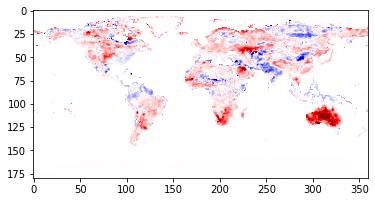

In [ ]:
kkk_non_conversion=get_sequence_map('non_conversion')
plt.imshow(kkk_non_conversion[-1]-kkk_non_conversion[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [01:44<00:00,  5.47s/it]


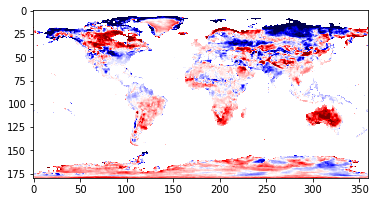

In [3]:
kkk_all=get_sequence_map('all')
plt.imshow(kkk_all[-1]-kkk_all[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

In [55]:
def rm_nan(data):
    data[np.isnan(data)]=0
    return data
tif_save_snowfre(rm_nan(kkk_snowfree[-1]-kkk_snowfree[0]),'snow-free_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(kkk_snow[-1]-kkk_snow[0]),'snow_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(kkk_conversion[-1]-kkk_conversion[0]),'conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(kkk_non_conversion[-1]-kkk_non_conversion[0]),'non-conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(kkk_all[-1]-kkk_all[0]),'all_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')

In [ ]:
zz=np.stack(kkk_snowfree)
zz_a2=np.stack(zz[:10]).reshape((10,60,-1,360)).reshape((10,60,3,120,-1)).transpose((0,1,3,2,4)).reshape((10,60,120,-1))
zz_a2=np.mean(zz_a2,axis=-1).reshape(10,-1).transpose((1,0))
zz_b2=np.stack(zz[10:]).reshape((10,60,-1,360)).reshape((10,60,3,120,-1)).transpose((0,1,3,2,4)).reshape((10,60,120,-1))
zz_b2=np.mean(zz_b2,axis=-1).reshape(10,-1).transpose((1,0))
t2,p2=t_test(zz_a2,zz_b2)
t_array2=np.array(t2).reshape(60,120)
p_array2=np.array(p2).reshape(60,120)
plt.figure(figsize=(20,30))
plt.imshow(p_array2)
plt.show()

NameError: name 'kkk_snowfree' is not defined

In [48]:
lat=np.array([88.5-3*i for i in range(60)]).reshape((60,1))*np.ones((1,120))
lon=np.array([-178.5+3*i for i in range(120)]).reshape((1,120))*np.ones((60,1))
lat[p_array2==0]=0
lon[p_array2==0]=0
lat=list(lat.reshape((-1,1)))
lon=list(lon.reshape((-1,1)))
coords=[[lat[i],lon[i]] for i in range(len(lat)) if lat[i]!=0]
from shapely import geometry
coords_geo=[geometry.Point(i[1],i[0]) for i in coords]
gpdd=gpd.GeoDataFrame.from_dict({'id':list(range(len(coords_geo))),'geometry':coords_geo})
gpdd=gpdd.set_crs(4326)
gpdd.to_file('significant.shp')

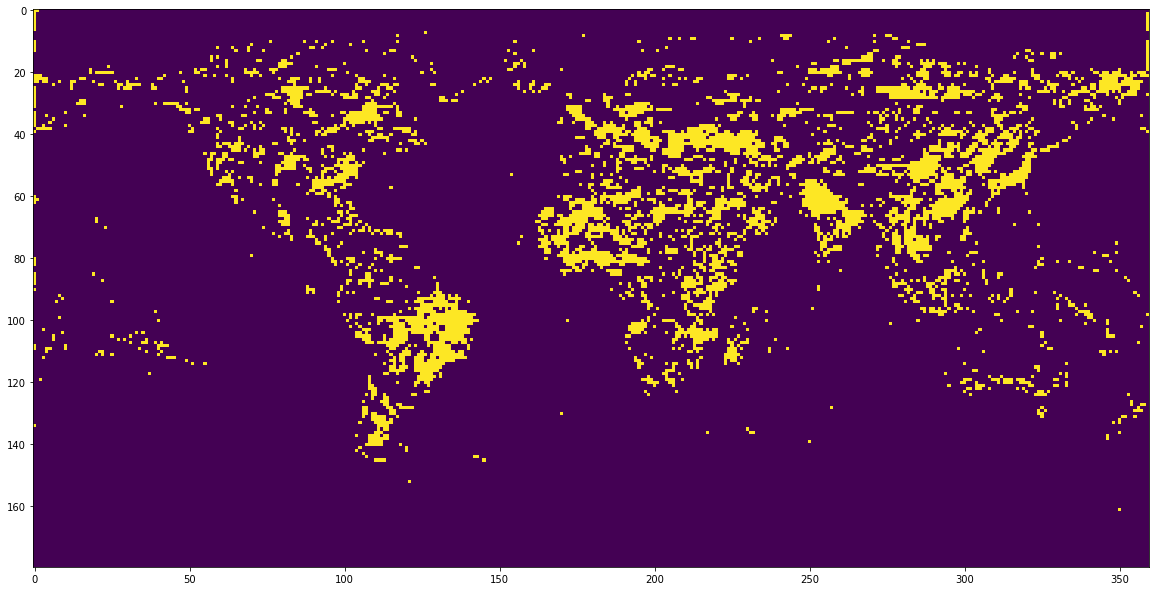

32.498699426651 %的snowfree区域反照率显著变化
22.945213317871094 %的snowfree区域反照率显著增长


In [32]:
zz_a=zz[:10].reshape(10,-1).transpose((1,0))
zz_b=zz[10:].reshape(10,-1).transpose((1,0))
t,p=t_test(zz_a,zz_b)
t_array=np.array(t).reshape(180,360)
p_array=np.array(p).reshape(180,360)
plt.figure(figsize=(20,30))
plt.imshow(p_array)
plt.show()
data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
data_m[mask_t>=1]=np.nan
data_m=month_fill(data_m,mask_t>=1)
data_m[:,:,:,-1,:]=0
data_m[:,:,:,:,-1]=0
data_m=np.nanmean(data_m,axis=0)
data_m=np.nansum(data_m,axis=-1)
data_m=np.nansum(data_m,axis=-1)
print((data_m*p_array).sum()/data_m.sum()*100,'%的snowfree区域反照率显著变化')
print((data_m*p_array*((kkk_snowfree[-1]-kkk_snowfree[0])>0).astype(np.int8)).sum()/data_m.sum()*100,'%的snowfree区域反照率显著增长')

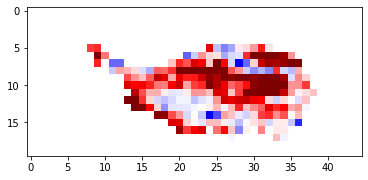

In [13]:
maskTP=np.load("/home/ubuntu/python_script/pybob/TPmask.npy")
zbd1=kkk_all[0].copy()
zbd1[maskTP==0]=np.nan
zbd2=kkk_all[-2].copy()
zbd2[maskTP==0]=np.nan
plt.imshow(zbd2[45:65,245:290]-zbd1[45:65,245:290],vmax=0.05,vmin=-0.05,cmap='seismic')

[]

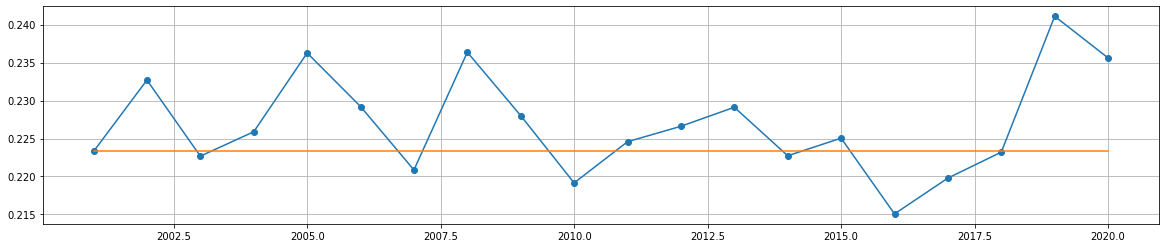

In [17]:
plt.figure(figsize=(20,4))
zbd_s=[]
for i in range(20):
    zbd=kkk_all[i].copy()
    zbd[maskTP==0]=np.nan
    zbd_s.append(np.nanmean(zbd))
plt.plot(list(range(2001,2021)),zbd_s,'o-')
plt.plot(list(range(2001,2021)),[zbd_s[0]]*20)
plt.grid()
plt.plot()

In [22]:
mk(zbd_s[:-2])

(0,
 0.12974504639571682,
 -0.00045528220022861965,
 -1.5151080381571405,
 [array([-0.00045528]), 0.22991278816714947])

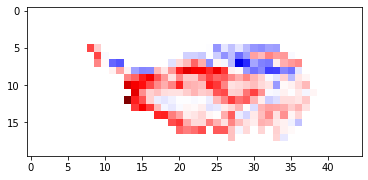

In [24]:
maskTP=np.load("/home/ubuntu/python_script/pybob/TPmask.npy")
zbd1=kkk_snowfree[0].copy()
zbd1[maskTP==0]=np.nan
zbd2=kkk_snowfree[-2].copy()
zbd2[maskTP==0]=np.nan
plt.imshow(zbd2[45:65,245:290]-zbd1[45:65,245:290],vmax=0.05,vmin=-0.05,cmap='seismic')


[]

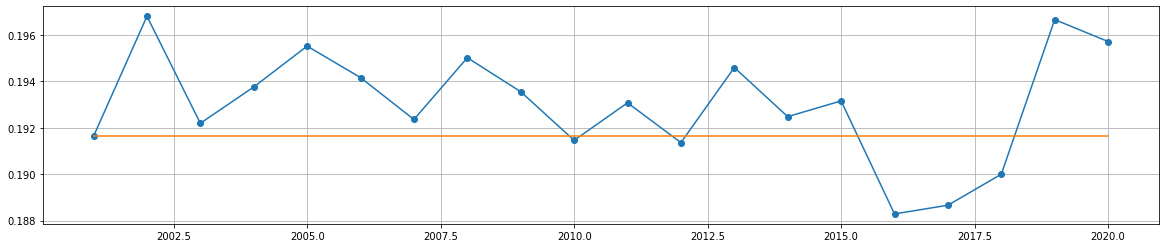

In [27]:
plt.figure(figsize=(20,4))
zbd_s=[]
for i in range(20):
    zbd=kkk_snowfree[i].copy()
    zbd[maskTP==0]=np.nan
    zbd_s.append(np.nanmean(zbd))
plt.plot(list(range(2001,2021)),zbd_s,'o-')
plt.plot(list(range(2001,2021)),[zbd_s[0]]*20)
plt.grid()
plt.plot()

In [31]:
mk(zbd_s[:-2])

(-1,
 0.03390907594960746,
 -0.0002524010937899531,
 -2.1211512534199968,
 [array([-0.0002524]), 0.19506453645520466])

In [86]:
from tool import *

def get_RF_map(mode):
    def filter_mode(data,mode):
        if mode=='snowfree':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
        elif mode=='all':
            pass
        elif mode=='snow':
            data[:,:,:,:-1,:-1]=0
        elif mode=='conversion':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
            for i in range(18):
                data[:,:,:,i,i]=0       
        elif mode=='non_conversion':
            mask_filter=np.zeros((18,18))
            for i in range(17):
                mask_filter[i,i]=1
            data=data*(mask_filter.reshape((1,1,1,18,18)))
        else:
            raise('ERROR MODE')
        return data
    mt=[]
    for month in range(1,13):
        now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=1)-now).total_seconds()
        mt.append(month_time)
    mt=np.array(mt)
    stat=torch.load(f'/data/hk/albedo/stat_sw-mean_sza-85_band-shortwave_kernel.pth')
    _,sza_L=torch.load(root_path+'sza_and_szaL.pth')


    energy_all=np.zeros((12,20,18,180,360)).astype(np.float32)
    area_all=np.zeros((12,20,18,180,360)).astype(np.float32)
    mask=np.zeros((12,20,18,180,360))

    for y in range(2001,2021):
        for m in range(1,13):
            energy_all[m-1,y-2001]=stat[f'{y}-{m}-energy']
            area_all[m-1,y-2001]=stat[f'{y}-{m}-typearea']
            mask[m-1,y-2001]=np.expand_dims(sza_L[y-2001,m-1],0).repeat(18,axis=0)
    # albedo_all=month_fill(albedo_all,mask>=1)
    energy_all[np.isnan(energy_all)]=0
    energy_all[mask>=2]=0
    energy_all=energy_all*mt.reshape((12,1,1,1,1))
    area_all[np.isnan(area_all)]=0
    area_all[mask>=2]=0

    data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')

    mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
    data_m[mask_t>=2]=np.nan
    data_m=month_fill(data_m,mask_t>=2)
    data_y=np.nanmean(data_m,axis=0)
    transf=np.nansum(data_y,axis=0)
    transf=np.nansum(transf,axis=0)
    dif_al=[]
    for m in range(12):
        exp1_2020=np.expand_dims(energy_all[m,-1]/area_all[m,-1],0).repeat(18,axis=0)
        exp0_2001=np.expand_dims(energy_all[m,0]/area_all[m,0],1).repeat(18,axis=1)
        dif_al_m=(exp1_2020-exp0_2001).transpose((2,3,0,1))*data_m[m]
        dif_al.append(dif_al_m)
    dif_al=np.stack(dif_al)
    data_y_all=np.nansum(data_y,axis=-1)
    data_y_all=np.nansum(data_y_all,axis=-1)

    dif_al_y=dif_al/365/24/3600/1e6
    dif_al_y=filter_mode(dif_al_y,mode)
    dif_al_y=np.nansum(dif_al_y,axis=0)
    dif_al_y=np.nansum(dif_al_y,axis=-1)
    dif_al_y=np.nansum(dif_al_y,axis=-1)
    output=dif_al_y/data_y_all
    return output
    





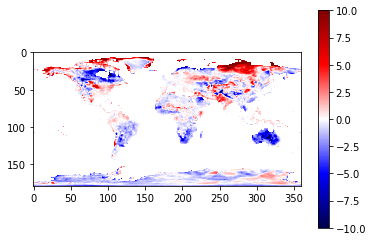

In [90]:
dif_all=get_RF_map('all')
plt.imshow(dif_all/1e6,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

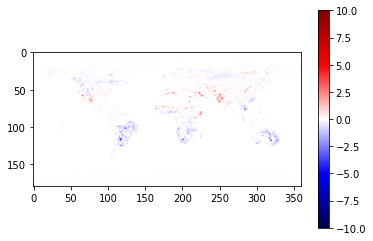

In [91]:
dif_conversion=get_RF_map('conversion')
plt.imshow(dif_conversion/1e6,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

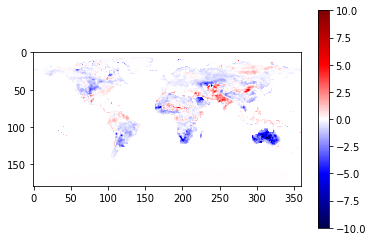

In [92]:
dif_non_conversion=get_RF_map('non_conversion')
plt.imshow(dif_non_conversion/1e6,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

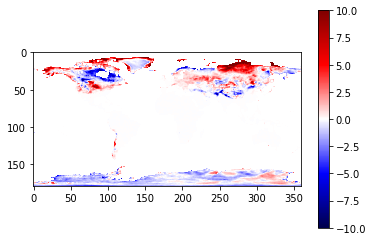

In [93]:
dif_snow=get_RF_map('snow')
plt.imshow(dif_snow/1e6,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

In [97]:
def rm_nan(data):
    data[np.isnan(data)]=0
    return data
tif_save_snowfre(rm_nan(dif_snow/1e6),'RF_snow_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(dif_conversion/1e6),'RF_conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(dif_non_conversion/1e6),'RF_non-conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save_snowfre(rm_nan(dif_all/1e6),'RF_all_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')

In [1]:
from tool import *
np.array([ 0.      , -0.17846 , -0.00526 ,  0.062328, -0.197714, -0.175554,
       -0.547536, -0.283216, -0.0315  , -0.35955 , -0.005814, -0.38292 ,
        0.056822, -0.564444, -0.668928, -0.861052, -0.330262,  0.0602  ,
       -0.689216, -0.756984])

array([ 0.      , -0.17846 , -0.00526 ,  0.062328, -0.197714, -0.175554,
       -0.547536, -0.283216, -0.0315  , -0.35955 , -0.005814, -0.38292 ,
        0.056822, -0.564444, -0.668928, -0.861052, -0.330262,  0.0602  ,
       -0.689216, -0.756984])

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression

def linear_outlier_detection(data, threshold=1.5):
    # 构建线性回归模型
    X = np.arange(len(data)).reshape(-1, 1)
    y = np.array(data).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    
    # 计算残差
    residuals = np.abs(y - model.predict(X))
    
    # 根据阈值识别异常点
    outliers = np.where(residuals > threshold * np.std(residuals))[0]
    
    return outliers

# 示例数据
time_series_data = [ 0.      , -0.17846 , -0.00526 ,  0.062328, -0.197714, -0.175554,
       -0.547536, -0.283216, -0.0315  , -0.35955 , -0.005814, -0.38292 ,
        0.056822, -0.564444, -0.668928, -0.861052, -0.330262,  0.0602  ,
       -0.689216, -0.756984]

# 线性异常点检测
detected_outliers = linear_outlier_detection(time_series_data)
print("Detected outliers:", detected_outliers)

Detected outliers: [ 6 10 12 14 15 17]


In [15]:
[time_series_data[i] for i in detected_outliers]

[-0.547536, -0.005814, 0.056822, -0.668928, -0.861052, 0.0602]